In [1]:
!pip install -q xgboost arch shap openpyxl

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
import pickle
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
import xgboost as xgb

# GARCH for volatility
from arch import arch_model

# SHAP for explanations
import shap

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All packages imported successfully")
print(f"📅 Notebook run timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✅ All packages imported successfully
📅 Notebook run timestamp: 2025-11-20 11:23:13


In [3]:
# ============================================================================
# SECTION 2: CONFIGURATION & FILE PATHS
# ============================================================================

# File paths
INPUT_FILE = "/content/drive/MyDrive/Colab Notebooks/Final year Project/preprocessed_no_leakage_sorted_2014_2024_CLEANED.csv"
OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs"
WORKING_DIR = "/content/drive/MyDrive/Colab Notebooks/Final year Project/"

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(WORKING_DIR, exist_ok=True)

# Initialize params dictionary (will be populated by interactive prompts at the end)
params = {
    'mode': 'immediate',
    'start_date': None,
    'horizon': 60,
    'region_type': 'global',
    'state': None,
    'district': None,
    'market_id': None,
    'winsorize_percentile': (1, 99), # Added for safe percentage change winsorization
    'use_log_transform': False, # Added to control log transformation of target
    'save_models': True, # Added to control model saving
    'save_plots': True, # Added to control plot saving
}

print("✅ Configuration loaded")
print(f"   Input file: {INPUT_FILE}")
print(f"   Output directory: {OUTPUT_DIR}")
print(f"ℹ️  NOTE: Interactive prompts have been moved to the final cell at the end of the notebook.")

✅ Configuration loaded
   Input file: /content/drive/MyDrive/Colab Notebooks/Final year Project/preprocessed_no_leakage_sorted_2014_2024_CLEANED.csv
   Output directory: /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs
ℹ️  NOTE: Interactive prompts have been moved to the final cell at the end of the notebook.


In [4]:
# ============================================================================
# SECTION 3: LOAD DATASET & SANITY CHECKS
# ============================================================================

print("\n" + "="*80)
print("📂 LOADING DATASET")
print("="*80)

# Load data
df = pd.read_csv(INPUT_FILE, low_memory=False)
print(f"✅ Loaded {len(df):,} rows")

# Convert date to datetime
date_col = 'date'
if date_col in df.columns:
    # Removed specific format to let pandas infer, handling various date formats
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    print(f"✅ Date converted and sorted")
else:
    raise ValueError("Date column not found in dataset")

# Extract year/month/day if not present
if 'year' not in df.columns:
    df['year'] = df[date_col].dt.year
if 'month' not in df.columns:
    df['month'] = df[date_col].dt.month
if 'day_of_week' not in df.columns:
    df['day_of_week'] = df[date_col].dt.dayofweek

# Identify target column
if 'modal_price' in df.columns:
    target_col = 'modal_price'
elif 'price_modal' in df.columns:
    target_col = 'price_modal'
    df.rename(columns={'price_modal': 'modal_price'}, inplace=True)
    target_col = 'modal_price'
elif 'modal_price_rs_qtl' in df.columns:
    df.rename(columns={'modal_price_rs_qtl': 'modal_price'}, inplace=True)
    target_col = 'modal_price'
else:
    raise ValueError("Target column 'modal_price' or 'price_modal' not found")

print(f"✅ Target column: {target_col}")

# Create market_id if not present
market_id_col = None
for col in ['market_id', 'state_district_market']:
    if col in df.columns:
        market_id_col = col
        break

if market_id_col is None:
    # Create composite market ID
    if all(col in df.columns for col in ['state', 'district', 'market']):
        df['market_id'] = df['state'] + '_' + df['district'] + '_' + df['market']
        market_id_col = 'market_id'
    else:
        raise ValueError("Cannot create market_id: missing state/district/market columns")

print(f"✅ Market ID column: {market_id_col}")

# Dataset summary
print(f"\n📊 Dataset Summary:")
print(f"   Date range: {df[date_col].min().date()} to {df[date_col].max().date()}")
print(f"   Total rows: {len(df):,}")
print(f"   Unique markets: {df[market_id_col].nunique()}")
print(f"   Years covered: {sorted(df['year'].unique())}")
print(f"   Target (modal_price) - Mean: ₹{df['modal_price'].mean():.2f}, Median: ₹{df['modal_price'].median():.2f}")


📂 LOADING DATASET
✅ Loaded 552,135 rows
✅ Date converted and sorted
✅ Target column: modal_price
✅ Market ID column: market_id

📊 Dataset Summary:
   Date range: 2014-05-31 to 2024-12-31
   Total rows: 552,135
   Unique markets: 616
   Years covered: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
   Target (modal_price) - Mean: ₹1931.31, Median: ₹1600.00


In [5]:
# ============================================================================
# SECTION 4: PIPELINE FUNCTION DEFINITION
# ============================================================================

def run_pipeline(df, params, verbose=True):
    """
    Complete forecasting pipeline from preprocessing to visualization.

    Parameters:
    -----------
    df : DataFrame
        Input dataset (can be filtered by region or full dataset)
    params : dict
        Configuration parameters including:
        - mode: 'immediate' or 'custom'
        - start_date: str, forecast start date (YYYY-MM-DD)
        - horizon: int, forecast horizon in days
        - region_type, state, district, market_id (optional)
    verbose : bool
        Whether to print detailed progress messages

    Returns:
    --------
    outputs : dict
        Dictionary containing:
        - models: trained XGBoost and Ridge models
        - forecast_output: DataFrame with forecasts and CI
        - metrics: dict of performance metrics
        - plot_paths: list of saved plot file paths
        - report_path: path to text report
    """

    if verbose:
        print("\n" + "="*80)
        print("⚙️  RUNNING FORECASTING PIPELINE")
        print("="*80)

    # ========================================================================
    # PREPROCESSING & FEATURE SELECTION
    # ========================================================================

    if verbose:
        print("\n" + "="*80)
        print("🔧 PREPROCESSING & FEATURE SELECTION")
        print("="*80)

    df = df.copy()  # Work with a copy

    # Explicitly drop leaky columns
    leaky_cols = [
        'modal_price_lag_30', 'price_index', 'max_price', 'min_price',
        'price_7d_avg', 'price_30d_avg', 'price_modal_7d_avg', 'price_modal_30d_avg',
        'change_price_modal', 'pct_change_price_modal'
    ]
    leaky_present = [col for col in leaky_cols if col in df.columns]
    if leaky_present:
        df.drop(columns=leaky_present, inplace=True)
        if verbose:
            print(f"✅ Dropped {len(leaky_present)} leaky columns")

    # Compute safe percentage changes
    df_sorted = df.sort_values([market_id_col, date_col]).copy()
    df_sorted['prev_price'] = df_sorted.groupby(market_id_col)['modal_price'].shift(1)
    df_sorted['price_change'] = df_sorted['modal_price'] - df_sorted['prev_price']
    df_sorted['safe_prev_price'] = df_sorted['prev_price'].clip(lower=1.0)
    df_sorted['safe_pct_change'] = (df_sorted['price_change'] / df_sorted['safe_prev_price']) * 100

    # Winsorize extreme percent changes
    lower_pct, upper_pct = 1, 99
    pct_lower = np.nanpercentile(df_sorted['safe_pct_change'].dropna(), lower_pct)
    pct_upper = np.nanpercentile(df_sorted['safe_pct_change'].dropna(), upper_pct)
    df_sorted['safe_pct_change_winsorized'] = df_sorted['safe_pct_change'].clip(pct_lower, pct_upper)

    df = df_sorted.copy()
    if verbose:
        print(f"✅ Computed safe percentage changes")

    # Feature selection
    potential_features = [
        'modal_price_lag_1', 'modal_price_lag_7', 'modal_price_pctchg_lag_30',
        'arrivals', 'quantity', 'arrivals_lag_7', 'arrivals_lag_30',
        'arrivals_pctchg_lag_7', 'arrivals_pctchg_lag_30', 'arrival_zero',
        'temp_max_C', 'temp_min_C', 'temp_avg_C', 'rainfall_mm',
        'avg_temp_avg_5m', 'avg_tmax_5m', 'avg_tmin_5m', 'avg_rain_5m',
        'temp_avg_expanding_mean', 'temp_avg_district_mean', 'temp_avg_anomaly',
        'cum_rain_ytd', 'cum_rain_5m', 'cum_rain_monsoon',
        'quantity_7d_avg', 'quantity_30d_avg',
        'price_volatility_7d', 'quantity_volatility_7d',
        'month', 'year', 'day_of_week',
        'is_festival', 'is_monsoon', 'price_spike', 'festival_flag',
        'state', 'district', market_id_col,
    ]

    available_features = [col for col in potential_features if col in df.columns]

    # Remove columns with >50% missing
    missing_pct = df[available_features].isnull().mean() * 100
    high_missing = missing_pct[missing_pct > 50].index.tolist()
    if high_missing:
        available_features = [col for col in available_features if col not in high_missing]
        if verbose:
            print(f"⚠️  Removed {len(high_missing)} features with >50% missing")

    if verbose:
        print(f"✅ Selected {len(available_features)} features")

    # Fill missing values
    numeric_features = df[available_features].select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = [col for col in available_features if col not in numeric_features]

    for col in numeric_features:
        df[col] = df.groupby(market_id_col)[col].fillna(method='ffill').fillna(method='bfill')
        df[col] = df[col].fillna(df[col].median())

    for col in categorical_features:
        df[col] = df[col].fillna('Unknown')

    if verbose:
        print(f"✅ Imputed missing values")

    # ========================================================================
    # TRAIN/TEST SPLIT
    # ========================================================================

    if verbose:
        print("\n" + "="*80)
        print("✂️  TRAIN/TEST SPLIT")
        print("="*80)

    train_df = df[df['year'] <= 2023].copy()
    test_df = df[df['year'] == 2024].copy()

    if verbose:
        print(f"✅ Training set: {len(train_df):,} rows")
        print(f"✅ Test set: {len(test_df):,} rows")

    # ========================================================================
    # TARGET ENCODING
    # ========================================================================

    if verbose:
        print("\n" + "="*80)
        print("🎯 TARGET ENCODING")
        print("="*80)

    def target_encode(train_df, test_df, cat_col, target_col):
        encoding_map = train_df.groupby(cat_col)[target_col].mean().to_dict()
        global_mean = train_df[target_col].mean()
        train_encoded = train_df[cat_col].map(encoding_map).fillna(global_mean)
        test_encoded = test_df[cat_col].map(encoding_map).fillna(global_mean)
        return train_encoded, test_encoded, encoding_map

    train_df['market_id_encoded'], test_df['market_id_encoded'], market_encoding = \
        target_encode(train_df, test_df, market_id_col, 'modal_price')

    if 'state' in categorical_features:
        train_df['state_encoded'], test_df['state_encoded'], _ = \
            target_encode(train_df, test_df, 'state', 'modal_price')

    if 'district' in categorical_features:
        train_df['district_encoded'], test_df['district_encoded'], _ = \
            target_encode(train_df, test_df, 'district', 'modal_price')

    feature_cols = [col for col in available_features if col not in [market_id_col, 'state', 'district']]
    feature_cols.extend(['market_id_encoded'])
    if 'state' in categorical_features:
        feature_cols.append('state_encoded')
    if 'district' in categorical_features:
        feature_cols.append('district_encoded')

    feature_cols = [col for col in feature_cols if col in train_df.select_dtypes(include=[np.number]).columns]

    if verbose:
        print(f"✅ Final feature count: {len(feature_cols)}")

    # Prepare X, y
    X_train = train_df[feature_cols].copy()
    y_train = train_df['modal_price'].copy()
    X_test = test_df[feature_cols].copy()
    y_test = test_df['modal_price'].copy()

    if verbose:
        print(f"✅ X_train shape: {X_train.shape}")
        print(f"✅ X_test shape: {X_test.shape}")

    # ========================================================================
    # MODEL TRAINING
    # ========================================================================

    if verbose:
        print("\n" + "="*80)
        print("🤖 MODEL TRAINING")
        print("="*80)

    # XGBoost
    xgb_params = {
        'n_estimators': 200,
        'learning_rate': 0.06,
        'max_depth': 6,
        'subsample': 0.85,
        'colsample_bytree': 0.85,
        'min_child_weight': 1,
        'reg_alpha': 0.03,
        'reg_lambda': 0.6,
        'random_state': 42,
        'n_jobs': -1,
        'objective': 'reg:squarederror'
    }

    if verbose:
        print("Training XGBoost...")
    xgb_model = xgb.XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train)

    # Ridge
    ridge_features = [col for col in feature_cols if 'lag_1' not in col]
    X_train_ridge = X_train[ridge_features]
    X_test_ridge = X_test[ridge_features]

    if verbose:
        print("Training Ridge...")
    ridge_model = Ridge(alpha=3.0, random_state=42)
    ridge_model.fit(X_train_ridge, y_train)

    if verbose:
        print("✅ Models trained")

    # Save models
    with open(os.path.join(WORKING_DIR, 'xgb_model.pkl'), 'wb') as f:
        pickle.dump(xgb_model, f)
    with open(os.path.join(WORKING_DIR, 'ridge_model.pkl'), 'wb') as f:
        pickle.dump(ridge_model, f)

    # ========================================================================
    # PREDICTIONS & METRICS
    # ========================================================================

    if verbose:
        print("\n" + "="*80)
        print("📊 PREDICTIONS & METRICS")
        print("="*80)

    y_train_pred_xgb = xgb_model.predict(X_train)
    y_test_pred_xgb = xgb_model.predict(X_test)
    y_train_pred_ridge = ridge_model.predict(X_train_ridge)
    y_test_pred_ridge = ridge_model.predict(X_test_ridge)

    y_train_actual = y_train
    y_test_actual = y_test

    def compute_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        return mae, rmse, r2

    train_mae_xgb, train_rmse_xgb, train_r2_xgb = compute_metrics(y_train_actual, y_train_pred_xgb)
    test_mae_xgb, test_rmse_xgb, test_r2_xgb = compute_metrics(y_test_actual, y_test_pred_xgb)
    train_mae_ridge, train_rmse_ridge, train_r2_ridge = compute_metrics(y_train_actual, y_train_pred_ridge)
    test_mae_ridge, test_rmse_ridge, test_r2_ridge = compute_metrics(y_test_actual, y_test_pred_ridge)

    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_mae_scores = -cross_val_score(xgb_model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    cv_r2_scores = cross_val_score(xgb_model, X_train, y_train, cv=tscv, scoring='r2', n_jobs=-1)
    cv_mae_mean = cv_mae_scores.mean()
    cv_mae_std = cv_mae_scores.std()
    cv_r2_mean = cv_r2_scores.mean()
    cv_r2_std = cv_r2_scores.std()

    if verbose:
        print("\n" + "=" * 80)
        print("📊 MODEL PERFORMANCE (2024-Calibrated)")
        print("=" * 80)
        print(f"{'Model':<20} {'Train MAE':<15} {'Train R²':<12} {'Test MAE':<15} {'Test R²':<12}")
        print("-" * 80)
        print(f"{'XGBoost':<20} {'₹' + f'{train_mae_xgb:.2f}':<14} {f'{train_r2_xgb:.4f}':<12} {'₹' + f'{test_mae_xgb:.2f}':<14} {f'{test_r2_xgb:.4f}':<12}")
        print(f"{'Ridge':<20} {'₹' + f'{train_mae_ridge:.2f}':<14} {f'{train_r2_ridge:.4f}':<12} {'₹' + f'{test_mae_ridge:.2f}':<14} {f'{test_r2_ridge:.4f}':<12}")
        print("=" * 80)
        print(f"🔄 Cross-Validation (XGBoost):")
        print(f"   CV MAE: ₹{cv_mae_mean:.2f} (±{cv_mae_std:.2f})")
        print(f"   CV R²:  {cv_r2_mean:.4f} (±{cv_r2_std:.4f})")
        print("=" * 80)

    metrics = {
        'train_mae_xgb': train_mae_xgb,
        'train_r2_xgb': train_r2_xgb,
        'test_mae_xgb': test_mae_xgb,
        'test_r2_xgb': test_r2_xgb,
        'train_mae_ridge': train_mae_ridge,
        'train_r2_ridge': train_r2_ridge,
        'test_mae_ridge': test_mae_ridge,
        'test_r2_ridge': test_r2_ridge,
        'cv_mae_mean': cv_mae_mean,
        'cv_mae_std': cv_mae_std,
        'cv_r2_mean': cv_r2_mean,
        'cv_r2_std': cv_r2_std
    }

    # Continue with forecasting sections...
    # (Continuing in next update due to length)

    return {
        'xgb_model': xgb_model,
        'ridge_model': ridge_model,
        'metrics': metrics,
        'feature_cols': feature_cols,
        'ridge_features': ridge_features,
        'market_encoding': market_encoding
    }


In [6]:
# ============================================================================
# SECTION 4: PREPROCESSING & FEATURE SELECTION

print("\n" + "="*80)
print("🔧 PREPROCESSING & FEATURE SELECTION")
print("="*80)

# Explicitly drop leaky columns
leaky_cols = [
    'modal_price_lag_30', 'price_index', 'max_price', 'min_price',
    'price_7d_avg', 'price_30d_avg', 'price_modal_7d_avg', 'price_modal_30d_avg',
    'change_price_modal', 'pct_change_price_modal'
]
leaky_present = [col for col in leaky_cols if col in df.columns]
if leaky_present:
    df.drop(columns=leaky_present, inplace=True)
    print(f"✅ Dropped {len(leaky_present)} leaky columns: {leaky_present}")

# Compute safe percentage changes for volatility features
# Handle zero/tiny previous prices
df_sorted = df.sort_values([market_id_col, date_col]).copy()
df_sorted['prev_price'] = df_sorted.groupby(market_id_col)['modal_price'].shift(1)
df_sorted['price_change'] = df_sorted['modal_price'] - df_sorted['prev_price']
df_sorted['safe_prev_price'] = df_sorted['prev_price'].clip(lower=1.0)
df_sorted['safe_pct_change'] = (df_sorted['price_change'] / df_sorted['safe_prev_price']) * 100

# Winsorize extreme percent changes
lower_pct, upper_pct = params['winsorize_percentile']
pct_lower = np.nanpercentile(df_sorted['safe_pct_change'].dropna(), lower_pct)
pct_upper = np.nanpercentile(df_sorted['safe_pct_change'].dropna(), upper_pct)
df_sorted['safe_pct_change_winsorized'] = df_sorted['safe_pct_change'].clip(pct_lower, pct_upper)

df = df_sorted.copy()
print(f"✅ Computed safe percentage changes (winsorized at {lower_pct}th-{upper_pct}th percentiles)")

# Feature list (legitimate features only)
potential_features = [
    # Lag features (legitimate)
    'modal_price_lag_1', 'modal_price_lag_7',
    'modal_price_pctchg_lag_30',

    # Arrivals
    'arrivals', 'quantity',
    'arrivals_lag_7', 'arrivals_lag_30',
    'arrivals_pctchg_lag_7', 'arrivals_pctchg_lag_30',
    'arrival_zero',

    # Weather
    'temp_max_C', 'temp_min_C', 'temp_avg_C',
    'rainfall_mm',

    # Seasonal aggregates
    'avg_temp_avg_5m', 'avg_tmax_5m', 'avg_tmin_5m', 'avg_rain_5m',

    # Anomalies
    'temp_avg_expanding_mean', 'temp_avg_district_mean', 'temp_avg_anomaly',

    # Rainfall cumulative
    'cum_rain_ytd', 'cum_rain_5m', 'cum_rain_monsoon',

    # Rolling windows (non-leaky)
    'quantity_7d_avg', 'quantity_30d_avg',
    'price_volatility_7d', 'quantity_volatility_7d',

    # Calendar
    'month', 'year', 'day_of_week',

    # Binary flags
    'is_festival', 'is_monsoon', 'price_spike', 'festival_flag',

    # Categorical
    'state', 'district', market_id_col,
]

# Filter to available columns
available_features = [col for col in potential_features if col in df.columns]
print(f"✅ Selected {len(available_features)} features from {len(potential_features)} potential")

# Remove columns with >50% missing
missing_pct = df[available_features].isnull().mean() * 100
high_missing = missing_pct[missing_pct > 50].index.tolist()
if high_missing:
    available_features = [col for col in available_features if col not in high_missing]
    print(f"⚠️  Removed {len(high_missing)} features with >50% missing: {high_missing}")

# Fill missing values
numeric_features = df[available_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [col for col in available_features if col not in numeric_features]

# Impute numeric: forward fill by market, then backward, then global median
for col in numeric_features:
    df[col] = df.groupby(market_id_col)[col].fillna(method='ffill').fillna(method='bfill')
    df[col] = df[col].fillna(df[col].median())

print(f"✅ Imputed missing values for {len(numeric_features)} numeric features")

# Fill categorical
for col in categorical_features:
    df[col] = df[col].fillna('Unknown')

print(f"✅ Filled categorical features: {len(categorical_features)}")



🔧 PREPROCESSING & FEATURE SELECTION
✅ Dropped 1 leaky columns: ['modal_price_lag_30']
✅ Computed safe percentage changes (winsorized at 1th-99th percentiles)
✅ Selected 25 features from 38 potential
✅ Imputed missing values for 21 numeric features
✅ Filled categorical features: 4


In [7]:
# ============================================================================
# SECTION 5: TRAIN/TEST SPLIT (TIME-BASED)
# ============================================================================

print("\n" + "="*80)
print("✂️  TRAIN/TEST SPLIT")
print("="*80)

# Split by year
train_df = df[df['year'] <= 2023].copy()
test_df = df[df['year'] == 2024].copy()

print(f"✅ Training set: {len(train_df):,} rows (years ≤ 2023)")
print(f"✅ Test set: {len(test_df):,} rows (year = 2024)")
print(f"   Train markets: {train_df[market_id_col].nunique()}")
print(f"   Test markets: {test_df[market_id_col].nunique()}")

# Identify unseen markets in test
train_markets = set(train_df[market_id_col].unique())
test_markets = set(test_df[market_id_col].unique())
unseen_markets = test_markets - train_markets
if unseen_markets:
    print(f"⚠️  {len(unseen_markets)} unseen markets in test set (will use global mean)")


✂️  TRAIN/TEST SPLIT
✅ Training set: 488,006 rows (years ≤ 2023)
✅ Test set: 64,129 rows (year = 2024)
   Train markets: 596
   Test markets: 423
⚠️  20 unseen markets in test set (will use global mean)


In [8]:
# ============================================================================
# SECTION 7: TARGET ENCODING FOR MARKET_ID
# ============================================================================

print("\n" + "="*80)
print("🎯 TARGET ENCODING")
print("="*80)

def target_encode(train_df, test_df, cat_col, target_col):
    """Target encode categorical column using train set means"""
    # Compute train means
    encoding_map = train_df.groupby(cat_col)[target_col].mean().to_dict()
    global_mean = train_df[target_col].mean()

    # Apply to train
    train_encoded = train_df[cat_col].map(encoding_map).fillna(global_mean)

    # Apply to test (unseen categories get global mean)
    test_encoded = test_df[cat_col].map(encoding_map).fillna(global_mean)

    return train_encoded, test_encoded, encoding_map

# Encode market_id
train_df['market_id_encoded'], test_df['market_id_encoded'], market_encoding = \
    target_encode(train_df, test_df, market_id_col, 'modal_price')

print(f"✅ Target-encoded {market_id_col} ({len(market_encoding)} unique values)")

# Encode state and district if present
if 'state' in categorical_features:
    train_df['state_encoded'], test_df['state_encoded'], _ = \
        target_encode(train_df, test_df, 'state', 'modal_price')
    print(f"✅ Target-encoded state")

if 'district' in categorical_features:
    train_df['district_encoded'], test_df['district_encoded'], _ = \
        target_encode(train_df, test_df, 'district', 'modal_price')
    print(f"✅ Target-encoded district")

# Update feature list (replace categorical with encoded)
feature_cols = [col for col in available_features if col not in [market_id_col, 'state', 'district']]
feature_cols.extend(['market_id_encoded'])
if 'state' in categorical_features:
    feature_cols.append('state_encoded')
if 'district' in categorical_features:
    feature_cols.append('district_encoded')

# Keep only numeric features for modeling
feature_cols = [col for col in feature_cols if col in train_df.select_dtypes(include=[np.number]).columns]

print(f"✅ Final feature count: {len(feature_cols)}")


🎯 TARGET ENCODING
✅ Target-encoded market_id (596 unique values)
✅ Target-encoded state
✅ Target-encoded district
✅ Final feature count: 24


In [9]:
# ============================================================================
# SECTION 8: PREPARE X, y
# ============================================================================

X_train = train_df[feature_cols].copy()
y_train = train_df['modal_price'].copy()

X_test = test_df[feature_cols].copy()
y_test = test_df['modal_price'].copy()

# Optional: log transform
if params['use_log_transform']:
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)
    print(f"✅ Applied log1p transform to target")

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")

✅ X_train shape: (488006, 24)
✅ X_test shape: (64129, 24)


In [10]:
# ============================================================================
# SECTION 9: MODEL TRAINING (REPLACEMENT - GLOBAL / PER_MARKET / CLUSTERED + STACKING)
# ============================================================================

print("\n" + "="*80)
print("🤖 MODEL TRAINING (ENHANCED + SANITIZATION FIX)")
print("="*80)

# local imports (safe to repeat in-section)
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
import joblib
import json
import math

# ---------------------------
# CONFIG: training behavior (change in params)
# ---------------------------
params.setdefault('training_mode', 'global')
params.setdefault('min_rows_per_market', 1000)
params.setdefault('markets_to_train', [])   # optional override
params.setdefault('use_cached_tuned_params', False)
params.setdefault('tuned_params_path', os.path.join(WORKING_DIR, 'tuned_params.json'))
params.setdefault('per_market_n_jobs', 2)

# ---------------------------
# Helper: sanitization - ensures no inf/very large numbers and no NaNs
# ---------------------------
def sanitize_X(X, lower_q=0.0005, upper_q=0.9995, verbose=True):
    """
    - Clips numeric columns at given quantiles to remove extreme outliers
    - Replaces inf with NaN, then fills NaN with column median
    - Casts to float32 to avoid extremely large values
    Returns sanitized copy.
    """
    Xs = X.copy()
    # select numeric columns
    numeric_cols = Xs.select_dtypes(include=[np.number]).columns.tolist()

    clipped_cols = []
    filled_with_median = []
    inf_count_total = 0
    nan_count_total = 0

    if len(numeric_cols) == 0:
        return Xs  # nothing to sanitize

    # compute quantiles per column robustly
    q_low = Xs[numeric_cols].quantile(lower_q)
    q_up  = Xs[numeric_cols].quantile(upper_q)

    for col in numeric_cols:
        col_arr = Xs[col].values

        # replace infinities with NaN temporarily
        inf_mask = ~np.isfinite(col_arr)
        if inf_mask.any():
            inf_count = int(inf_mask.sum())
            inf_count_total += inf_count
            col_arr[inf_mask] = np.nan

        # clip using quantiles (skip if constant or nan)
        low = q_low.get(col, None)
        up = q_up.get(col, None)
        try:
            if (low is not None and not pd.isna(low)) and (up is not None and not pd.isna(up)) and (low < up):
                # ensure numeric
                col_arr = np.where(col_arr < low, low, col_arr)
                col_arr = np.where(col_arr > up, up, col_arr)
                clipped_cols.append(col)
        except Exception:
            pass

        Xs[col] = col_arr

    # Now fill NaNs with median (computed from sanitized values)
    for col in numeric_cols:
        nan_before = int(Xs[col].isna().sum())
        if nan_before > 0:
            med = float(Xs[col].median(skipna=True)) if not pd.isna(Xs[col].median(skipna=True)) else 0.0
            Xs[col] = Xs[col].fillna(med)
            filled_with_median.append(col)
            nan_count_total += nan_before

    # Final pass: ensure finite and reasonable scale: replace any remaining infinities and huge values
    for col in numeric_cols:
        arr = Xs[col].values.astype(np.float64)
        # Replace any non-finite with median
        nonfinite_mask = ~np.isfinite(arr)
        if nonfinite_mask.any():
            arr[nonfinite_mask] = float(np.nanmedian(arr[np.isfinite(arr)]) if np.any(np.isfinite(arr)) else 0.0)
        # Cap absolute values at a conservative maximum (e.g., 1e7) to avoid XGBoost complaining about huge numbers
        big_mask = np.abs(arr) > 1e7
        if big_mask.any():
            arr[big_mask] = np.sign(arr[big_mask]) * 1e7
        Xs[col] = arr.astype(np.float32)

    if verbose:
        print(f"ℹ️  Sanitized X: numeric_cols={len(numeric_cols)}, clipped_cols={len(clipped_cols)}, inf_fixed={inf_count_total}, nan_filled={nan_count_total}")

    return Xs

# ---------------------------
# Helper: feature engineering enhancement (applied to train_df/test_df)
# (if you already applied earlier keep this idempotent)
# ---------------------------
def enhance_features(df_in, market_id_col, date_col):
    """Add rolling stats and seasonal dummies. Operates in place-ish (returns copy)."""
    df_e = df_in.copy()
    df_e = df_e.sort_values([market_id_col, date_col]).reset_index(drop=True)

    # Rolling statistics per market
    roll_windows = [3, 7, 14, 30]
    for w in roll_windows:
        col_mean = f'roll_mean_{w}'
        col_med  = f'roll_med_{w}'
        col_std  = f'roll_std_{w}'
        df_e[col_mean] = df_e.groupby(market_id_col)['modal_price'].transform(lambda x: x.rolling(w, min_periods=1).mean())
        df_e[col_med]  = df_e.groupby(market_id_col)['modal_price'].transform(lambda x: x.rolling(w, min_periods=1).median())
        df_e[col_std]  = df_e.groupby(market_id_col)['modal_price'].transform(lambda x: x.rolling(w, min_periods=1).std().fillna(0.0))

    # Momentum / acceleration proxies
    df_e['pct_chg_1'] = df_e.groupby(market_id_col)['modal_price'].pct_change(1).fillna(0.0) * 100.0
    df_e['pct_chg_7'] = df_e.groupby(market_id_col)['modal_price'].pct_change(7).fillna(0.0) * 100.0
    df_e['accel_7_1'] = df_e['pct_chg_1'] - df_e['pct_chg_7']

    # Seasonal features: month, quarter, is_month_start
    df_e['month'] = pd.to_datetime(df_e[date_col]).dt.month
    df_e['quarter'] = pd.to_datetime(df_e[date_col]).dt.quarter
    df_e['is_month_start'] = pd.to_datetime(df_e[date_col]).dt.is_month_start.astype(int)

    # Holiday flags: placeholder - you can load a holiday calendar and merge by date
    if 'is_holiday' not in df_e.columns:
        df_e['is_holiday'] = 0  # placeholder: merge your holiday calendar here

    # Distance from short-term moving average
    df_e['dist_from_roll7'] = (df_e['modal_price'] - df_e['roll_mean_7']).fillna(0.0)

    # Fill/fix remaining NA
    numeric_cols = df_e.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        df_e[col] = df_e[col].fillna(df_e[col].median())

    return df_e

# If feature enhancement hasn't been applied already in the notebook, apply now.
# If it has, enhance_features is idempotent for existing columns.
print("Enhancing features for train & test data (this may take a moment)...")
train_df = enhance_features(train_df, market_id_col, date_col)
test_df  = enhance_features(test_df, market_id_col, date_col)
print("✅ Feature enhancement completed")

# Update feature_cols: include newly engineered features if present
engineered = [c for c in train_df.columns if any(s in c for s in ['roll_mean_', 'roll_med_', 'roll_std_', 'pct_chg_', 'accel_', 'dist_from_roll7', 'quarter', 'is_month_start', 'is_holiday'])]
engineered = [c for c in engineered if c not in ['modal_price', 'prev_price']]
feature_cols = sorted(list(set(feature_cols + engineered)))
print(f"✅ Updated feature_cols length -> {len(feature_cols)} (added {len(engineered)} engineered features)")

# ---------------------------
# Pre-check: tuned params loader (optional)
# ---------------------------
tuned_params = {}
if params.get('use_cached_tuned_params') and os.path.exists(params['tuned_params_path']):
    try:
        with open(params['tuned_params_path'], 'r') as f:
            tuned_params = json.load(f)
        print(f"✅ Loaded tuned params from {params['tuned_params_path']} ({len(tuned_params)} entries)")
    except Exception as e:
        print(f"⚠️  Failed to load tuned params: {e}. Will proceed without them.")

# ---------------------------
# Base XGBoost defaults (safe)
# ---------------------------
base_xgb_defaults = {
    'n_estimators': 300,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.85,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'reg_alpha': 0.03,
    'reg_lambda': 0.6,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
    'verbosity': 0
}

# ---------------------------
# Training helpers
# ---------------------------
def train_xgb(X, y, params_override=None):
    cfg = base_xgb_defaults.copy()
    if params_override:
        cfg.update(params_override)
    # ensure arrays are numeric and finite
    Xs = sanitize_X(X)
    ys = y.fillna(y.median()).values
    model = xgb.XGBRegressor(**cfg)
    model.fit(Xs, ys)
    return model

def evaluate_model(model, X, y, name='Model'):
    Xs = sanitize_X(X, verbose=False)
    preds = model.predict(Xs)
    mae = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    r2 = r2_score(y, preds)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.4f}")
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

# ---------------------------
# TRAINING MODES
# ---------------------------

trained_models = {}
model_metrics = {}
ridge_features = [c for c in feature_cols if 'lag_1' not in c]

training_mode = params.get('training_mode', 'global')
print(f"Training mode: {training_mode}")

if training_mode == 'global':
    # Prepare data
    X_train = train_df[feature_cols].copy()
    y_train = train_df['modal_price'].copy()
    X_test = test_df[feature_cols].copy()
    y_test = test_df['modal_price'].copy()

    # sanitize & align columns (important)
    X_train_s = sanitize_X(X_train)
    X_test_s  = sanitize_X(X_test)

    # Align columns (in case some engineered features exist only in one split)
    missing_in_test = [c for c in X_train_s.columns if c not in X_test_s.columns]
    for c in missing_in_test:
        X_test_s[c] = X_train_s[c].median()
    missing_in_train = [c for c in X_test_s.columns if c not in X_train_s.columns]
    for c in missing_in_train:
        X_train_s[c] = X_test_s[c].median()

    # Ensure same column order
    X_test_s = X_test_s[X_train_s.columns]

    # Use tuned params if provided for 'GLOBAL' key
    global_override = tuned_params.get('GLOBAL', None) if tuned_params else None
    print("Training global XGBoost model...")
    try:
        xgb_model = train_xgb(X_train_s, y_train, global_override)
    except Exception as e:
        print(f"⚠️  XGBoost training failed on sanitized data: {e}")
        # fallback: try lighter params
        fallback = base_xgb_defaults.copy()
        fallback.update({'n_estimators':100, 'learning_rate':0.08, 'max_depth':4})
        xgb_model = train_xgb(X_train_s, y_train, fallback)
        print("✅ Fallback XGBoost trained")

    # Ridge
    print("Training Ridge (same as before)...")
    ridge_model = Ridge(alpha=3.0, random_state=42)
    ridge_model.fit(X_train_s[ridge_features], y_train)

    # stacking (meta-model)
    print("Fitting stacking regressor (XGB + Ridge meta)...")
    estimators = [('xgb', xgb_model), ('ridge', ridge_model)]
    stacking = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=1.0), n_jobs=-1, passthrough=True)
    stacking.fit(X_train_s, y_train)

    # evaluate
    print("\nGlobal model performance (Train):")
    model_metrics['global_train'] = evaluate_model(stacking, X_train_s, y_train, name='Stacking(Global)-Train')
    print("\nGlobal model performance (Test):")
    model_metrics['global_test'] = evaluate_model(stacking, X_test_s, y_test, name='Stacking(Global)-Test')

    # save
    if params.get('save_models', True):
        p_x = os.path.join(WORKING_DIR, 'xgb_model_global.pkl')
        p_r = os.path.join(WORKING_DIR, 'ridge_model_global.pkl')
        p_s = os.path.join(WORKING_DIR, 'stacking_model_global.pkl')
        joblib.dump(xgb_model, p_x)
        joblib.dump(ridge_model, p_r)
        joblib.dump(stacking, p_s)
        trained_models['GLOBAL'] = {'xgb': p_x, 'ridge': p_r, 'stacking': p_s}
        print(f"✅ Saved global models -> {p_x}, {p_r}, {p_s}")

elif training_mode == 'per_market':
    all_markets = sorted(train_df[market_id_col].unique())
    markets_selected = params.get('markets_to_train') if params.get('markets_to_train') else [m for m in all_markets if len(train_df[train_df[market_id_col]==m]) >= params['min_rows_per_market']]
    print(f"Markets selected for per-market training: {len(markets_selected)} (min rows: {params['min_rows_per_market']})")

    for m in markets_selected:
        df_m_train = train_df[train_df[market_id_col]==m].copy()
        df_m_test  = test_df[test_df[market_id_col]==m].copy()
        if len(df_m_train) < 50:
            print(f"Skipping {m} (insufficient rows: {len(df_m_train)})")
            continue

        Xtr = df_m_train[feature_cols].copy()
        ytr = df_m_train['modal_price'].copy()
        Xte = df_m_test[feature_cols].copy() if len(df_m_test)>0 else None
        yte = df_m_test['modal_price'].copy() if len(df_m_test)>0 else None

        # sanitize and align
        Xtr_s = sanitize_X(Xtr)
        if Xte is not None:
            Xte_s = sanitize_X(Xte)
            # align
            for c in Xtr_s.columns:
                if c not in Xte_s.columns:
                    Xte_s[c] = Xtr_s[c].median()
            for c in Xte_s.columns:
                if c not in Xtr_s.columns:
                    Xtr_s[c] = Xte_s[c].median()
            Xte_s = Xte_s[Xtr_s.columns]
        else:
            Xte_s = None

        override = tuned_params.get(m, None) if tuned_params else None

        try:
            mdl = train_xgb(Xtr_s, ytr, override)
            # ridge (per-market)
            rmdl = Ridge(alpha=3.0, random_state=42)
            ridge_feats = [c for c in feature_cols if 'lag_1' not in c]
            rmdl.fit(Xtr_s[ridge_feats], ytr)

            # stacking
            stack = StackingRegressor(estimators=[('xgb', mdl), ('ridge', rmdl)],
                                      final_estimator=Ridge(alpha=1.0),
                                      n_jobs=1, passthrough=True)
            stack.fit(Xtr_s, ytr)

            # evaluate on market test (if exists) else on last part of train via holdout
            if Xte_s is not None and len(Xte_s)>0:
                metrics = evaluate_model(stack, Xte_s, yte, name=f"Stacking({m})-Test")
            else:
                metrics = evaluate_model(stack, Xtr_s.tail(min(100, len(Xtr_s))), ytr.tail(min(100, len(Xtr_s))), name=f"Stacking({m})-InSampleTail")

            # save
            if params.get('save_models', True):
                dirp = os.path.join(WORKING_DIR, f"models_per_market")
                os.makedirs(dirp, exist_ok=True)
                safe_name = m.replace('/','_').replace(' ','_')
                p_x = os.path.join(dirp, f"xgb_{safe_name}.pkl")
                p_r = os.path.join(dirp, f"ridge_{safe_name}.pkl")
                p_s = os.path.join(dirp, f"stack_{safe_name}.pkl")
                joblib.dump(mdl, p_x)
                joblib.dump(rmdl, p_r)
                joblib.dump(stack, p_s)
                trained_models[m] = {'xgb': p_x, 'ridge': p_r, 'stacking': p_s}
                model_metrics[m] = metrics
                print(f"✅ Saved models for {m} -> {p_s}")
        except Exception as e:
            print(f"⚠️  Training failed for {m}: {e}")

    print("\nPer-market training completed. Trained models count:", len(trained_models))

elif training_mode == 'clustered':
    market_stats = train_df.groupby(market_id_col)['modal_price'].agg(['mean','std']).fillna(0.0)
    n_clusters = min(6, max(2, market_stats.shape[0]//50))
    km = KMeans(n_clusters=n_clusters, random_state=42)
    market_stats['cluster'] = km.fit_predict(market_stats[['mean','std']])
    print(f"Clustering markets into {n_clusters} clusters")

    for cluster_id in sorted(market_stats['cluster'].unique()):
        market_list = market_stats[market_stats['cluster']==cluster_id].index.tolist()
        df_cluster = train_df[train_df[market_id_col].isin(market_list)].copy()
        if len(df_cluster) < 200:
            print(f"  Skipping cluster {cluster_id} (too small: {len(df_cluster)} rows)")
            continue
        Xtr = df_cluster[feature_cols]
        ytr = df_cluster['modal_price']
        override = tuned_params.get(f"CLUSTER_{cluster_id}", None)
        Xtr_s = sanitize_X(Xtr)
        mdl = train_xgb(Xtr_s, ytr, override)
        rmdl = Ridge(alpha=3.0, random_state=42)
        ridge_feats = [c for c in feature_cols if 'lag_1' not in c]
        rmdl.fit(Xtr_s[ridge_feats], ytr)
        stack = StackingRegressor(estimators=[('xgb', mdl), ('ridge', rmdl)],
                                  final_estimator=Ridge(alpha=1.0),
                                  n_jobs=-1, passthrough=True)
        stack.fit(Xtr_s, ytr)
        if params.get('save_models', True):
            dirp = os.path.join(WORKING_DIR, f"models_clustered")
            os.makedirs(dirp, exist_ok=True)
            p_s = os.path.join(dirp, f"stack_cluster_{cluster_id}.pkl")
            joblib.dump(stack, p_s)
            trained_models[f"CLUSTER_{cluster_id}"] = {'stacking': p_s}
            print(f"✅ Saved cluster model -> {p_s}")

    print("Clustered training completed.")

else:
    raise ValueError(f"Unknown training_mode: {training_mode}")

# final: persist metadata about trained models and feature_cols
meta = {
    'trained_models': trained_models,
    'feature_cols': feature_cols,
    'ridge_features': ridge_features,
    'training_mode': training_mode,
    'timestamp': datetime.now().isoformat(),
    'model_metrics_sample': {k:v for k,v in list(model_metrics.items())[:10]}
}
meta_path = os.path.join(WORKING_DIR, f"trained_models_meta_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(meta_path, 'w') as f:
    json.dump(meta, f, indent=2)
print(f"✅ Training metadata saved -> {meta_path}")

# expose important objects to globals (so later sections can use them)
globals().update({
    'trained_models': trained_models,
    'model_metrics': model_metrics,
    'feature_cols': feature_cols,
    'ridge_features': ridge_features,
})



🤖 MODEL TRAINING (ENHANCED + SANITIZATION FIX)
Enhancing features for train & test data (this may take a moment)...
✅ Feature enhancement completed
✅ Updated feature_cols length -> 43 (added 19 engineered features)
Training mode: global
ℹ️  Sanitized X: numeric_cols=43, clipped_cols=41, inf_fixed=212, nan_filled=212
ℹ️  Sanitized X: numeric_cols=43, clipped_cols=40, inf_fixed=0, nan_filled=0
Training global XGBoost model...
ℹ️  Sanitized X: numeric_cols=43, clipped_cols=41, inf_fixed=0, nan_filled=0
Training Ridge (same as before)...
Fitting stacking regressor (XGB + Ridge meta)...

Global model performance (Train):
Stacking(Global)-Train: MAE=41.86, RMSE=654.52, R2=0.7382

Global model performance (Test):
Stacking(Global)-Test: MAE=59.39, RMSE=333.14, R2=0.9729
✅ Saved global models -> /content/drive/MyDrive/Colab Notebooks/Final year Project/xgb_model_global.pkl, /content/drive/MyDrive/Colab Notebooks/Final year Project/ridge_model_global.pkl, /content/drive/MyDrive/Colab Notebooks/

In [11]:
# # ----------------------------
# # SECTION 9.1 - Global stacking + optional global tuning (FIXED)
# # HYPERPARAMETER TUNING (COMPLETE)
# # ----------------------------
# print("\n" + "="*80)
# print("🤖 MODEL TRAINING (SECTION 9.1: Global Stacking + optional tuning) - FIXED")
# print("="*80)
#
# import json
# from sklearn.ensemble import StackingRegressor
# from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from joblib import dump
#
# # Where to save global artifacts
# GLOBAL_MODELS_DIR = os.path.join(WORKING_DIR, "models", "global")
# os.makedirs(GLOBAL_MODELS_DIR, exist_ok=True)
#
# # Flag to control heavy tuning for global model
# tune_global = params.get('tune_global', True)
#
# # sensible default hyperparameters (safe)
# default_xgb_params = {
#     'n_estimators': 200,
#     'learning_rate': 0.05,
#     'max_depth': 8,
#     'subsample': 1.0,
#     'colsample_bytree': 0.85,
#     'min_child_weight': 1,
#     'reg_alpha': 0.05,
#     'reg_lambda': 1.0,
#     'random_state': 42,
#     'n_jobs': -1,
#     'objective': 'reg:squarederror',
#     'verbosity': 0
# }
#
# # --- Helper: sanitize DataFrame for XGBoost / CV
# def sanitize_df_for_xgb(X, lower_q=0.0005, upper_q=0.9995, cap_abs=1e7, verbose=False):
#     #Clip numeric columns at quantiles, replace inf with NaN, fill NaN with median,
#     #cap extremely large values, and ensure float32 dtype.
#
#     Xs = X.copy()
#     numeric_cols = Xs.select_dtypes(include=[np.number]).columns.tolist()
#     if len(numeric_cols) == 0:
#         return Xs
#
#     # Replace inf/-inf with NaN
#     Xs[numeric_cols] = Xs[numeric_cols].replace([np.inf, -np.inf], np.nan)
#
#     # Compute quantiles
#     q_low = Xs[numeric_cols].quantile(lower_q)
#     q_up  = Xs[numeric_cols].quantile(upper_q)
#
#     for c in numeric_cols:
#         col = Xs[c]
#         # If column entirely NaN, fill with 0
#         if col.isnull().all():
#             Xs[c] = 0.0
#             continue
#         low = q_low[c] if c in q_low.index else col.min()
#         high = q_up[c] if c in q_up.index else col.max()
#         # If low==high (constant), skip clip
#         if not pd.isna(low) and not pd.isna(high) and low < high:
#             Xs[c] = col.clip(lower=low, upper=high)
#         # Fill NaNs with median
#         med = float(Xs[c].median(skipna=True)) if not pd.isna(Xs[c].median(skipna=True)) else 0.0
#         Xs[c] = Xs[c].fillna(med)
#         # Cap absolute values
#         Xs[c] = np.where(np.abs(Xs[c]) > cap_abs, np.sign(Xs[c]) * cap_abs, Xs[c])
#
#     # Final replace any remaining non-finite with median
#     for c in numeric_cols:
#         arr = Xs[c].values
#         nonfinite = ~np.isfinite(arr)
#         if nonfinite.any():
#             med = float(np.nanmedian(arr[np.isfinite(arr)]) if np.any(np.isfinite(arr)) else 0.0)
#             arr[nonfinite] = med
#             Xs[c] = arr
#
#     # Cast numeric to float32 to keep XGBoost happy
#     Xs[numeric_cols] = Xs[numeric_cols].astype(np.float32)
#
#     if verbose:
#         print(f"sanitize_df_for_xgb: cleaned {len(numeric_cols)} numeric columns")
#
#     return Xs
#
# print("Training mode: global")
#
# # Make sure train/test are aligned to feature_cols and numeric_features from earlier
# X_train_global = X_train.copy()
# X_test_global  = X_test.copy()
#
# # Ensure all feature_cols present in both
# for c in feature_cols:
#     if c not in X_train_global.columns:
#         # default fill: median from full df if available otherwise 0
#         X_train_global[c] = df[c].median() if c in df.columns else 0.0
#     if c not in X_test_global.columns:
#         X_test_global[c] = df[c].median() if c in df.columns else 0.0
#
# # Re-order columns consistently
# X_train_global = X_train_global[feature_cols].copy()
# X_test_global  = X_test_global[feature_cols].copy()
#
# # sanitize numeric columns robustly
# print("Sanitizing X_train ...")
# X_train_global_s = sanitize_df_for_xgb(X_train_global, verbose=True)
# X_test_global_s  = sanitize_df_for_xgb(X_test_global, verbose=True)
#
# print(f"Final shapes -- X_train: {X_train_global_s.shape} X_test: {X_test_global_s.shape}")
#
# # Base models
# global_xgb = xgb.XGBRegressor(**default_xgb_params)
# global_ridge = Ridge(alpha=3.0, random_state=42)
#
# # Optionally tune global XGBoost (light tuning)
# best_global_params = default_xgb_params.copy()
# if tune_global:
#     print("🔎 Running light RandomizedSearchCV for global XGBoost (this may take time)...")
#     param_dist = {
#         'n_estimators': [100, 150, 200, 300],
#         'learning_rate': [0.03, 0.05, 0.08],
#         'max_depth': [6, 8, 10],
#         'subsample': [0.75, 0.85, 1.0],
#         'colsample_bytree': [0.6, 0.75, 0.85],
#         'reg_alpha': [0.0, 0.03, 0.05],
#         'reg_lambda': [0.6, 1.0, 1.5]
#     }
#     # Use fewer splits to speed up and avoid tiny fold sizes
#     tscv_global = TimeSeriesSplit(n_splits=3)
#     # Use a single-process RandomizedSearch to avoid nested parallelism issues with XGBoost
#     rs = RandomizedSearchCV(
#         estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1, verbosity=0),
#         param_distributions=param_dist,
#         n_iter=20,
#         scoring='neg_mean_absolute_error',
#         cv=tscv_global,
#         verbose=1,
#         n_jobs=1,
#         random_state=42,
#         error_score=np.nan
#     )
#
#     try:
#         # Fit on sanitized data
#         rs.fit(X_train_global_s, y_train)
#         best_global_params = rs.best_params_
#         print("Global tuning done. Best params:", best_global_params)
#     except Exception as e:
#         # If tuning fails, fall back gracefully to defaults and print the exception
#         print(f"⚠️  Global RandomizedSearchCV failed: {e}")
#         print("⚠️  Falling back to default_xgb_params for global model.")
#         best_global_params = default_xgb_params.copy()
#
# else:
#     print("Skipping global tuning; using default_xgb_params as best params.")
#     best_global_params = default_xgb_params.copy()
#
# # Build final global_xgb with best params (ensure verbosity off)
# final_xgb_cfg = best_global_params.copy()
# final_xgb_cfg.update({'objective':'reg:squarederror','random_state':42,'n_jobs':-1,'verbosity':0})
# global_xgb = xgb.XGBRegressor(**final_xgb_cfg)
#
# # Fit XGBoost and Ridge on entire sanitized training set
# print("Training global XGBoost model (sanitized features)...")
# try:
#     global_xgb.fit(X_train_global_s, y_train)
# except Exception as e:
#     print(f"⚠️  XGBoost training failed on sanitized data: {e}")
#     # fallback to safer small model
#     fallback_cfg = final_xgb_cfg.copy()
#     fallback_cfg.update({'n_estimators':100,'learning_rate':0.08,'max_depth':4})
#     print("Attempting fallback XGBoost configuration...")
#     global_xgb = xgb.XGBRegressor(**fallback_cfg)
#     global_xgb.fit(X_train_global_s, y_train)
#     print("✅ Fallback XGBoost trained")
#
# print("Training Ridge (same as before)...")
# global_ridge.fit(X_train_global_s[ridge_features], y_train)
#
# # Now create stacking model (meta model: Ridge)
# estimators = [
#     ('xgb', global_xgb),
#     ('ridge', global_ridge)
# ]
# stacking = StackingRegressor(
#     estimators=estimators, final_estimator=Ridge(alpha=1.0),
#     passthrough=False, n_jobs=-1
# )
#
# print("Fitting stacking regressor (XGB + Ridge meta)...")
# stacking.fit(X_train_global_s, y_train)
#
# # Evaluate and save
# def eval_print(name, Xtr, ytr, Xte, yte, model):
#     Xtr_s = sanitize_df_for_xgb(Xtr, verbose=False)
#     Xte_s = sanitize_df_for_xgb(Xte, verbose=False)
#     # Align columns
#     for c in Xtr_s.columns:
#         if c not in Xte_s.columns:
#             Xte_s[c] = Xtr_s[c].median()
#     for c in Xte_s.columns:
#         if c not in Xtr_s.columns:
#             Xtr_s[c] = Xte_s[c].median()
#     Xte_s = Xte_s[Xtr_s.columns]
#     ytr_p = model.predict(Xtr_s)
#     yte_p = model.predict(Xte_s)
#     tr_mae = mean_absolute_error(ytr, ytr_p)
#     tr_rmse = np.sqrt(mean_squared_error(ytr, ytr_p))
#     tr_r2 = r2_score(ytr, ytr_p)
#     te_mae = mean_absolute_error(yte, yte_p)
#     te_rmse = np.sqrt(mean_squared_error(yte, yte_p))
#     te_r2 = r2_score(yte, yte_p)
#     print(f"\nGlobal model performance (Train):")
#     print(f"{name}-Train: MAE={tr_mae:.2f}, RMSE={tr_rmse:.2f}, R2={tr_r2:.4f}")
#     print(f"\nGlobal model performance (Test):")
#     print(f"{name}-Test: MAE={te_mae:.2f}, RMSE={te_rmse:.2f}, R2={te_r2:.4f}")
#     return dict(train_mae=tr_mae, train_rmse=tr_rmse, train_r2=tr_r2,
#                 test_mae=te_mae, test_rmse=te_rmse, test_r2=te_r2)
#
# global_metrics = eval_print("Stacking(Global)", X_train_global_s, y_train, X_test_global_s, y_test, stacking)
#
# # Save models and metadata
# dump(global_xgb, os.path.join(GLOBAL_MODELS_DIR, 'xgb_model_global.joblib'))
# dump(global_ridge, os.path.join(GLOBAL_MODELS_DIR, 'ridge_model_global.joblib'))
# dump(stacking, os.path.join(GLOBAL_MODELS_DIR, 'stacking_model_global.joblib'))
#
# meta = {
#     'best_global_params': best_global_params,
#     'global_metrics': global_metrics,
#     'feature_cols': feature_cols,
#     'ridge_features': ridge_features,
#     'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
# }
# with open(os.path.join(GLOBAL_MODELS_DIR, 'global_models_meta.json'), 'w') as f:
#     json.dump(meta, f, indent=2)
#
# print(f"✅ Saved global models -> {GLOBAL_MODELS_DIR}")
# print(f"✅ Training metadata saved -> {os.path.join(GLOBAL_MODELS_DIR, 'global_models_meta.json')}")



In [12]:
# ============================================================================
# SECTION 9.2 - PER-STATE TRAINING (NEW) - train one model per state and save
# NOTE: TRAINING BLOCKS COMMENTED OUT (loader-only mode). If you want to retrain,
#       uncomment the training loop below or set params['retrain_if_missing']=True
# ============================================================================
print("\n" + "="*80)
print("🤖 MODEL TRAINING (SECTION 9.2: PER-STATE MODELS - LOADER MODE)")
print("="*80)

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge as SkRidge
import joblib
import json
from datetime import datetime
import math

# Configuration (can be adjusted through params)
params.setdefault('per_state_min_rows', 500)      # min training rows to build a state model
params.setdefault('states_to_train', [])         # optional list of states to restrict training
params.setdefault('per_state_n_jobs', 1)         # internal parallelism for stacking final_estimator
params.setdefault('save_models', True)
# If you want the loader to retrain missing state models automatically, set this True.
# BE CAREFUL: retraining may be heavy. Default False for loader-only behavior.
params.setdefault('retrain_if_missing', False)

PER_STATE_DIR = os.path.join(WORKING_DIR, "models_per_state")
os.makedirs(PER_STATE_DIR, exist_ok=True)

# Choose XGBoost parameter source
xgb_param_source = {}
if 'best_global_params' in globals() and isinstance(best_global_params, dict):
    xgb_param_source = best_global_params.copy()
elif 'default_xgb_params' in globals():
    xgb_param_source = default_xgb_params.copy()
else:
    xgb_param_source = {
        'n_estimators': 150, 'learning_rate': 0.06, 'max_depth': 6,
        'subsample': 0.85, 'colsample_bytree': 0.8,
        'reg_alpha': 0.03, 'reg_lambda': 0.6, 'random_state': 42,
        'objective': 'reg:squarederror', 'n_jobs': 1, 'verbosity': 0
    }

# Ensure final XGBoost settings are safe for per-state training (force n_jobs=1 here to avoid nested parallel)
xgb_param_source.update({'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': 1, 'verbosity': 0})

# Collect states to train / load
all_states = sorted(train_df['state'].dropna().unique())
states_selected = params.get('states_to_train') if params.get('states_to_train') else all_states
print(f"States found: {len(all_states)}. States selected for processing: {len(states_selected)}")

trained_state_models = {}
state_metrics = {}

# ---------------------------
# LOADER: attempt to load existing per-state models from disk
# ---------------------------
for state in states_selected:
    safe_name = state.replace('/','_').replace(' ','_')
    state_dir = os.path.join(PER_STATE_DIR, safe_name)
    p_x = os.path.join(state_dir, f"xgb_{safe_name}.joblib")
    p_r = os.path.join(state_dir, f"ridge_{safe_name}.joblib")
    p_s = os.path.join(state_dir, f"stack_{safe_name}.joblib")

    # if directory exists and stack file exists, try to load
    if os.path.exists(p_s):
        try:
            stack_state = joblib.load(p_s)
            # optionally try to load xgb and ridge (not strictly required if stacking contains them)
            xgb_state = joblib.load(p_x) if os.path.exists(p_x) else None
            ridge_state = joblib.load(p_r) if os.path.exists(p_r) else None
            trained_state_models[state] = {'xgb': p_x if xgb_state is not None else None,
                                           'ridge': p_r if ridge_state is not None else None,
                                           'stacking': p_s}
            state_metrics[state] = {'note': 'loaded_from_disk'}
            print(f"   ✅ Loaded state model for {state} -> {p_s}")
            continue
        except Exception as e:
            print(f"   ⚠️  Failed to load model for {state} (corrupt/old): {e} - will mark as missing")

    # If model missing on disk, mark missing
    trained_state_models[state] = {'xgb': None, 'ridge': None, 'stacking': None}
    state_metrics[state] = {'note': 'missing_on_disk'}
    print(f"   ℹ️  No saved model for {state} (expected path: {p_s})")

# ---------------------------
# OPTIONAL: Automatic retrain for missing states (COMMENTED OUT by default)
# If you want to retrain missing models automatically, set params['retrain_if_missing'] = True.
# The original training loop is preserved below but commented — uncomment to enable.
# ---------------------------

if params.get('retrain_if_missing', False):
    print("\n⚠️  retrain_if_missing=True -> attempting to train missing state models now (this may be heavy)")
    for state in states_selected:
        if trained_state_models.get(state, {}).get('stacking') is not None:
            continue  # already loaded

        # Build per-state dataframes
        df_tr_state = train_df[train_df['state'] == state].copy()
        df_te_state = test_df[test_df['state'] == state].copy()
        ntr = len(df_tr_state)
        nte = len(df_te_state)

        if ntr < params['per_state_min_rows']:
            print(f"   ⚠️  Skipping {state} for training (insufficient rows: {ntr} < {params['per_state_min_rows']})")
            state_metrics[state] = {'note': 'insufficient_rows_for_training', 'train_rows': ntr}
            continue

        # Prepare training arrays (reuse sanitize helper if available)
        Xtr = df_tr_state[feature_cols].copy()
        ytr = df_tr_state['modal_price'].copy()
        Xte = df_te_state[feature_cols].copy() if nte>0 else None
        yte = df_te_state['modal_price'].copy() if nte>0 else None

        try:
            # sanitize (use sanitize_df_for_xgb if present else fallback)
            if 'sanitize_df_for_xgb' in globals():
                Xtr_s = sanitize_df_for_xgb(Xtr)
                Xte_s = sanitize_df_for_xgb(Xte) if Xte is not None else None
            else:
                # simple sanitization: clip to quantiles and fillna with median
                def _simple_sanitize(X):
                    if X is None: return None
                    Xs = X.copy()
                    for c in Xs.select_dtypes(include=[np.number]).columns:
                        col = Xs[c]
                        low = col.quantile(0.0005)
                        high = col.quantile(0.9995)
                        Xs[c] = col.clip(lower=low, upper=high).fillna(col.median())
                    return Xs
                Xtr_s = _simple_sanitize(Xtr)
                Xte_s = _simple_sanitize(Xte) if Xte is not None else None

            # pick params
            xgb_cfg = xgb_param_source.copy()
            xgb_cfg.update({'n_jobs': 1, 'verbosity': 0, 'random_state': 42})

            # train models
            print(f"   Training XGBoost for state {state} ...")
            xgb_state = xgb.XGBRegressor(**xgb_cfg)
            xgb_state.fit(Xtr_s, ytr)

            print(f"   Training Ridge for state {state} ...")
            ridge_state = SkRidge(alpha=3.0, random_state=42)
            ridge_state.fit(Xtr_s[ridge_features], ytr)

            print(f"   Fitting stacking regressor for state {state} ...")
            estimators = [('xgb', xgb_state), ('ridge', ridge_state)]
            stack_state = StackingRegressor(estimators=estimators, final_estimator=SkRidge(alpha=1.0),
                                           passthrough=False, n_jobs=params.get('per_state_n_jobs',1))
            stack_state.fit(Xtr_s, ytr)

            # save to disk
            safe_name = state.replace('/','_').replace(' ','_')
            state_dir = os.path.join(PER_STATE_DIR, safe_name)
            os.makedirs(state_dir, exist_ok=True)
            p_x = os.path.join(state_dir, f"xgb_{safe_name}.joblib")
            p_r = os.path.join(state_dir, f"ridge_{safe_name}.joblib")
            p_s = os.path.join(state_dir, f"stack_{safe_name}.joblib")
            if params.get('save_models', True):
                joblib.dump(xgb_state, p_x)
                joblib.dump(ridge_state, p_r)
                joblib.dump(stack_state, p_s)
                trained_state_models[state] = {'xgb': p_x, 'ridge': p_r, 'stacking': p_s}
                state_metrics[state] = {'note': 'trained_and_saved', 'train_rows': ntr, 'test_rows': nte}
                print(f"   ✅ Trained & saved state model for {state} -> {p_s}")
            else:
                trained_state_models[state] = {'xgb': None, 'ridge': None, 'stacking': None}
                state_metrics[state] = {'note': 'trained_not_saved', 'train_rows': ntr, 'test_rows': nte}

        except Exception as e:
            print(f"   ⚠️  Training failed for {state}: {e}")
            state_metrics[state] = {'error': str(e), 'train_rows': ntr}

else:
    print("\nℹ️  retrain_if_missing=False (default). Missing state models will not be trained automatically.")

# Save summary meta
meta_state = {
    'trained_states_count': len([s for s,v in trained_state_models.items() if v.get('stacking')]),
    'trained_states': [s for s,v in trained_state_models.items() if v.get('stacking')],
    'state_metrics_sample': {k:v for k,v in list(state_metrics.items())[:50]},
    'feature_cols': feature_cols,
    'ridge_features': ridge_features,
    'timestamp': datetime.now().isoformat()
}
meta_path_state = os.path.join(PER_STATE_DIR, f"per_state_models_meta_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
with open(meta_path_state, 'w') as f:
    json.dump(meta_state, f, indent=2)
print("\n✅ Per-state processing completed.")
print(f"   State models dir: {PER_STATE_DIR}")
print(f"   Meta saved: {meta_path_state}")
print(f"   Trained/Loaded states (sample): {list(trained_state_models.keys())[:10]}")

# expose to globals for downstream sections
globals().update({
    'trained_state_models': trained_state_models,
    'state_metrics': state_metrics,
    'per_state_models_meta': meta_state
})



🤖 MODEL TRAINING (SECTION 9.2: PER-STATE MODELS - LOADER MODE)
States found: 23. States selected for processing: 23
   ✅ Loaded state model for Andhra Pradesh -> /content/drive/MyDrive/Colab Notebooks/Final year Project/models_per_state/Andhra_Pradesh/stack_Andhra_Pradesh.joblib
   ✅ Loaded state model for Assam -> /content/drive/MyDrive/Colab Notebooks/Final year Project/models_per_state/Assam/stack_Assam.joblib
   ✅ Loaded state model for Bihar -> /content/drive/MyDrive/Colab Notebooks/Final year Project/models_per_state/Bihar/stack_Bihar.joblib
   ✅ Loaded state model for Chandigarh -> /content/drive/MyDrive/Colab Notebooks/Final year Project/models_per_state/Chandigarh/stack_Chandigarh.joblib
   ✅ Loaded state model for Goa -> /content/drive/MyDrive/Colab Notebooks/Final year Project/models_per_state/Goa/stack_Goa.joblib
   ✅ Loaded state model for Gujarat -> /content/drive/MyDrive/Colab Notebooks/Final year Project/models_per_state/Gujarat/stack_Gujarat.joblib
   ✅ Loaded state m

In [13]:
# ---------- Run this BEFORE SECTION 10 ----------
import numpy as np
import pandas as pd

def sanitize_X_df(X, numeric_cols=None, lower_q=0.0005, upper_q=0.9995, max_abs_allowed=None, verbose=True):
    Xs = X.copy()
    if numeric_cols is None:
        numeric_cols = Xs.select_dtypes(include=[np.number]).columns.tolist()

    report = {'cols_with_inf': [], 'cols_with_nan': [], 'cols_clipped': [], 'cols_casted': [], 'cols_huge_before': []}
    # detect huge threshold if not provided: use 1e12 as fallback
    if max_abs_allowed is None:
        max_abs_allowed = 1e12

    for c in numeric_cols:
        if c not in Xs.columns:
            continue
        col = Xs[c].astype('float64')  # attempt cast
        # detect +inf/-inf
        has_inf = np.isinf(col).any()
        if has_inf:
            report['cols_with_inf'].append(c)
            col = col.replace([np.inf, -np.inf], np.nan)
        # detect nan before fill
        if col.isnull().any():
            report['cols_with_nan'].append(c)
        # detect extremely large values
        huge_mask = col.abs() > max_abs_allowed
        if huge_mask.any():
            report['cols_huge_before'].append(c)
            col[huge_mask] = np.nan

        # quantile clipping
        try:
            low = col.quantile(lower_q)
            high = col.quantile(upper_q)
            clipped = False
            if (col < low).any() or (col > high).any():
                clipped = True
                col = col.clip(lower=low, upper=high)
            if clipped:
                report['cols_clipped'].append(c)
        except Exception:
            # if quantile fails (constant column), continue
            pass

        # fill remaining NaNs with median (safe fallback)
        if col.isnull().any():
            med = float(col.median()) if not pd.isna(col.median()) else 0.0
            col = col.fillna(med)

        # final cast
        if not np.issubdtype(col.dtype, np.floating):
            try:
                col = col.astype('float64')
                report['cols_casted'].append(c)
            except Exception:
                # leave as-is if cannot cast
                pass

        Xs[c] = col

    if verbose:
        print("Sanitization report:")
        print("  cols_with_inf:", len(report['cols_with_inf']), report['cols_with_inf'][:10])
        print("  cols_with_nan (before fill):", len(report['cols_with_nan']))
        print("  cols_clipped:", len(report['cols_clipped']), report['cols_clipped'][:10])
        print("  cols_huge_before:", len(report['cols_huge_before']), report['cols_huge_before'][:10])
        print("  cols_casted:", len(report['cols_casted']))
        # quick checks
        n_inf_after = np.isinf(Xs.select_dtypes(include=[np.number])).sum().sum()
        n_nan_after = Xs.select_dtypes(include=[np.number]).isnull().sum().sum()
        n_large_after = (Xs.select_dtypes(include=[np.number]).abs() > max_abs_allowed).sum().sum()
        print(f"  >>> after sanitize: total inf={n_inf_after}, total nan={n_nan_after}, values>|{max_abs_allowed}|={n_large_after}")
    return Xs, report

# Apply to your train/test X before Section 10 predictions
numeric_feature_cols = [c for c in feature_cols if c in X_train.columns]  # use existing list
X_train_sanitized, rep_train = sanitize_X_df(X_train, numeric_feature_cols)
X_test_sanitized, rep_test = sanitize_X_df(X_test, numeric_feature_cols)

# Replace the X_train/X_test variables used by Section 10 with sanitized versions
X_train = X_train_sanitized
X_test  = X_test_sanitized

# Quick model-predict smoke-test (use a small sample to avoid long compute)
try:
    if 'stacking' in globals():
        _ = stacking.predict(X_test.head(20))
    elif 'xgb_model' in globals():
        _ = xgb_model.predict(X_test.head(20))
    else:
        print("No model object found in globals for smoke-test.")
    print("✅ Smoke-test predict OK on small sample.")
except Exception as e:
    print("❌ Smoke-test predict failed:", repr(e))
    # If fails, print a few diagnostic values for top offending columns
    bad_cols = []
    for c in numeric_feature_cols:
        col = X_test[c]
        if np.isinf(col).any() or col.isnull().any() or (col.abs() > 1e12).any():
            bad_cols.append(c)
    print("Candidate problematic columns (sample):", bad_cols[:20])


Sanitization report:
  cols_with_inf: 3 ['accel_7_1', 'pct_chg_1', 'pct_chg_7']
  cols_with_nan (before fill): 3
  cols_clipped: 34 ['accel_7_1', 'arrivals_lag_30', 'arrivals_lag_7', 'arrivals_pctchg_lag_30', 'arrivals_pctchg_lag_7', 'avg_rain_5m', 'avg_temp_avg_5m', 'avg_tmax_5m', 'avg_tmin_5m', 'cum_rain_5m']
  cols_huge_before: 1 ['modal_price_pctchg_lag_30']
  cols_casted: 0
  >>> after sanitize: total inf=0, total nan=0, values>|1000000000000.0|=0
Sanitization report:
  cols_with_inf: 0 []
  cols_with_nan (before fill): 0
  cols_clipped: 34 ['accel_7_1', 'arrivals_lag_30', 'arrivals_lag_7', 'arrivals_pctchg_lag_30', 'arrivals_pctchg_lag_7', 'avg_rain_5m', 'avg_temp_avg_5m', 'avg_tmax_5m', 'avg_tmin_5m', 'cum_rain_5m']
  cols_huge_before: 0 []
  cols_casted: 0
  >>> after sanitize: total inf=0, total nan=0, values>|1000000000000.0|=0
✅ Smoke-test predict OK on small sample.


In [14]:
# ============================================================================
# SECTION 10: PREDICTIONS & METRICS (REPLACEMENT - robust sanitization & safe eval)
# ============================================================================

print("\n" + "="*80)
print("📊 PREDICTIONS & METRICS")
print("="*80)

import math
from joblib import load as joblib_load

# ---------- Helpers ----------
def safe_load_model_from_paths(paths):
    """Try a list of paths/varnames to load a model object. Returns first available or None."""
    for p in paths:
        # if object present in globals, return it
        if isinstance(p, str) and p in globals():
            obj = globals().get(p)
            if obj is not None:
                return obj
        # if it's a filepath, try joblib.load / pickle
        try:
            if isinstance(p, str) and os.path.exists(p):
                try:
                    return joblib_load(p)
                except Exception:
                    try:
                        with open(p, 'rb') as f:
                            return pickle.load(f)
                    except Exception:
                        continue
        except Exception:
            continue
    return None

def sanitize_X(X, numeric_cols=None, lower_q=0.0005, upper_q=0.9995, max_abs_threshold=1e12):
    """
    Sanitizes a dataframe X in-place (returns sanitized copy):
      - Replace +inf/-inf with NaN
      - Clip numeric columns to quantiles [lower_q, upper_q]
      - Fill NaNs with column median
      - Replace extremely large values (abs>max_abs_threshold) with median
      - Ensure dtype float64
    """
    Xs = X.copy()
    # convert numeric-like to numeric dtype safely
    for col in Xs.columns:
        # if numeric dtype or convertible, cast to float
        try:
            if numeric_cols is None or col in numeric_cols:
                Xs[col] = pd.to_numeric(Xs[col], errors='coerce')
        except Exception:
            pass

    if numeric_cols is None:
        numeric_cols = Xs.select_dtypes(include=[np.number]).columns.tolist()

    clipped_cols = []
    inf_fixed = 0
    nan_filled = 0

    for c in numeric_cols:
        if c not in Xs.columns:
            continue
        col = Xs[c]
        # replace inf with NaN
        n_inf_before = np.isinf(col).sum() if len(col)>0 else 0
        if n_inf_before > 0:
            col = col.replace([np.inf, -np.inf], np.nan)
            inf_fixed += int(n_inf_before)
        # compute quantiles safely (skip if all NaN)
        if col.dropna().empty:
            Xs[c] = col.fillna(0.0)
            continue
        low = col.quantile(lower_q)
        high = col.quantile(upper_q)
        # clip to quantiles
        if not np.isnan(low) and not np.isnan(high):
            col = col.clip(lower=low, upper=high)
            clipped_cols.append(c)
        # replace absurdly large values
        med = col.median()
        col = col.mask(col.abs() > max_abs_threshold, med)
        # fill NaNs with median
        n_na_before = col.isna().sum()
        if n_na_before > 0:
            col = col.fillna(med)
            nan_filled += int(n_na_before)
        Xs[c] = col.astype('float64')

    # final global check - any remaining non-finite values -> replace with column median
    for c in numeric_cols:
        if c in Xs.columns:
            col = Xs[c]
            mask = ~np.isfinite(col)
            if mask.any():
                med = col[~mask].median() if (~mask).any() else 0.0
                Xs.loc[mask, c] = med
                inf_fixed += int(mask.sum())

    # return plus some stats
    stats = {
        'numeric_cols': len(numeric_cols),
        'clipped_cols': len(clipped_cols),
        'inf_fixed': int(inf_fixed),
        'nan_filled': int(nan_filled)
    }
    return Xs, stats

def compute_metrics_dict(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

# ---------- Prepare X/y (use feature_cols defined earlier) ----------
# If feature_cols changed during training, ensure X_train/X_test use the same set (they should)
X_train_local = X_train.copy()
X_test_local  = X_test.copy()
y_train_local = y_train.copy()
y_test_local  = y_test.copy()

# sanitize using numeric_features (if defined)
numeric_feature_cols = [c for c in feature_cols if c in numeric_features] if 'numeric_features' in globals() else X_train_local.select_dtypes(include=[np.number]).columns.tolist()

X_train_sanitized, stats_train = sanitize_X(X_train_local, numeric_feature_cols)
X_test_sanitized, stats_test = sanitize_X(X_test_local, numeric_feature_cols)

print(f"ℹ️  Sanitized X: numeric_cols={stats_train['numeric_cols']}, clipped_cols={stats_train['clipped_cols']}, inf_fixed={stats_train['inf_fixed']}, nan_filled={stats_train['nan_filled']}")
print(f"ℹ️  Sanitized X: numeric_cols={stats_test['numeric_cols']}, clipped_cols={stats_test['clipped_cols']}, inf_fixed={stats_test['inf_fixed']}, nan_filled={stats_test['nan_filled']}")

# ---------- Choose evaluation model (prefer stacking meta-model if present) ----------
# Try several common names/paths where a stacking meta-model might be stored or present in globals
possible_stacking_sources = [
    'stacking',                      # in-memory stacking object (common)
    'stacking_model',                # alternate variable name
    'stack',                         # sometimes used
    os.path.join(WORKING_DIR, 'stacking_model_global.pkl'),
    os.path.join(WORKING_DIR, 'stacking_model_global.joblib'),
    os.path.join(WORKING_DIR, 'stacking_model_global.pkl'),
    os.path.join(WORKING_DIR, 'stacking_model_global.joblib'),
    os.path.join(WORKING_DIR, 'stacking_model_global.pkl')  # duplicate attempts harmless
]
eval_model = safe_load_model_from_paths(possible_stacking_sources)

# If no stacking, fallback to xgb_model if available
if eval_model is None:
    eval_model = safe_load_model_from_paths(['stacking', 'stack', 'stacking_model_global', 'xgb_model', 'xgb_model_global'])
    if eval_model is None:
        # try to use in-memory objects (xgb_model/ridge_model)
        if 'xgb_model' in globals():
            eval_model = xgb_model
        elif 'stacking' in globals():
            eval_model = stacking
        else:
            eval_model = None

# Info
if eval_model is not None:
    print(f"ℹ️  Using model for evaluation: {getattr(eval_model,'__class__', type(eval_model)).__name__}")
else:
    print("⚠️  No stacking/XGB model object found in globals or expected paths. Will attempt per-model predictions.")

# ---------- Predictions & metrics ----------
# We'll attempt: 1) predict with eval_model (stacking preferred). If it fails, attempt direct xgb/ridge predictions and compose metrics.
y_train_pred_xgb = None
y_test_pred_xgb  = None
y_train_pred_ridge = None
y_test_pred_ridge  = None

metrics = {}

# Try eval_model predict
if eval_model is not None:
    try:
        y_train_pred_eval = eval_model.predict(X_train_sanitized)
        y_test_pred_eval  = eval_model.predict(X_test_sanitized)
        # If eval_model is stacking, also try to extract underlying xgb/ridge predictions if possible
        print("ℹ️  Eval model predicted successfully.")
        # For compatibility with later code that expects xgb/ridge preds, try to produce those:
        try:
            if hasattr(eval_model, 'estimators_') or hasattr(eval_model, 'estimators'):
                # if stacking object, try to get sub-estimators
                # sklearn StackingRegressor: estimators_ attribute exists after fit
                ests = getattr(eval_model, 'estimators_', getattr(eval_model, 'estimators', None))
                # If the stacking stores fitted estimators, we can attempt to call predict on first estimator as xgb proxy
                if ests and len(ests) > 0:
                    first_est = ests[0]
                    try:
                        y_train_pred_xgb = first_est.predict(X_train_sanitized)
                        y_test_pred_xgb  = first_est.predict(X_test_sanitized)
                    except Exception:
                        # fallback to global xgb_model if present
                        if 'xgb_model' in globals():
                            try:
                                y_train_pred_xgb = xgb_model.predict(X_train_sanitized)
                                y_test_pred_xgb  = xgb_model.predict(X_test_sanitized)
                            except Exception:
                                y_train_pred_xgb = None
                                y_test_pred_xgb = None
                else:
                    # fallback direct xgb_model in globals
                    if 'xgb_model' in globals():
                        try:
                            y_train_pred_xgb = xgb_model.predict(X_train_sanitized)
                            y_test_pred_xgb  = xgb_model.predict(X_test_sanitized)
                        except Exception:
                            y_train_pred_xgb = None
                            y_test_pred_xgb = None
            else:
                # eval_model is not stacking - could be xgb directly
                if hasattr(eval_model, 'predict'):
                    try:
                        # assume eval_model is xgb-like
                        y_train_pred_xgb = eval_model.predict(X_train_sanitized)
                        y_test_pred_xgb  = eval_model.predict(X_test_sanitized)
                    except Exception:
                        y_train_pred_xgb = None
                        y_test_pred_xgb = None
        except Exception:
            pass

        # assign stacking preds into variables for later use (if direct xgb preds not available, use eval preds)
        if y_train_pred_xgb is None:
            y_train_pred_xgb = y_train_pred_eval
            y_test_pred_xgb  = y_test_pred_eval

        # compute eval metrics using the eval_model predictions
        metrics['eval_model'] = {
            'train': compute_metrics_dict(y_train_local, y_train_pred_eval),
            'test': compute_metrics_dict(y_test_local, y_test_pred_eval)
        }

    except Exception as e:
        print(f"⚠️  Model predict failed (Input X contains infinity or a value too large for dtype('float64').). Falling back to individual models if available. Error: {str(e)[:200]}")
        eval_model = None

# If eval_model failed or not present -> try direct XGBoost / Ridge
if eval_model is None:
    # try to get xgb_model from globals or from trained_models metadata
    xgb_model_to_eval = None
    ridge_model_to_eval = None
    if 'xgb_model' in globals():
        xgb_model_to_eval = xgb_model
    else:
        # try common file names
        candidate = safe_load_model_from_paths([os.path.join(WORKING_DIR, 'xgb_model_global.pkl'), os.path.join(WORKING_DIR, 'xgb_model_global.joblib'), os.path.join(WORKING_DIR, 'xgb_model.pkl')])
        if candidate is not None:
            xgb_model_to_eval = candidate

    if 'ridge_model' in globals():
        ridge_model_to_eval = ridge_model
    else:
        candidate = safe_load_model_from_paths([os.path.join(WORKING_DIR, 'ridge_model_global.pkl'), os.path.join(WORKING_DIR, 'ridge_model.pkl')])
        if candidate is not None:
            ridge_model_to_eval = candidate

    # XGBoost predictions
    if xgb_model_to_eval is not None:
        try:
            y_train_pred_xgb = xgb_model_to_eval.predict(X_train_sanitized)
            y_test_pred_xgb  = xgb_model_to_eval.predict(X_test_sanitized)
            metrics['xgb'] = {
                'train': compute_metrics_dict(y_train_local, y_train_pred_xgb),
                'test': compute_metrics_dict(y_test_local, y_test_pred_xgb)
            }
            print("ℹ️  XGBoost predictions successful.")
        except Exception as e:
            print(f"⚠️  XGBoost predict failed: {e}")
            y_train_pred_xgb = None
            y_test_pred_xgb = None

    # Ridge predictions
    if ridge_model_to_eval is not None:
        try:
            ridge_feat_cols = [c for c in ridge_features if c in X_train_sanitized.columns]
            y_train_pred_ridge = ridge_model_to_eval.predict(X_train_sanitized[ridge_feat_cols])
            y_test_pred_ridge  = ridge_model_to_eval.predict(X_test_sanitized[ridge_feat_cols])
            metrics['ridge'] = {
                'train': compute_metrics_dict(y_train_local, y_train_pred_ridge),
                'test': compute_metrics_dict(y_test_local, y_test_pred_ridge)
            }
            print("ℹ️  Ridge predictions successful.")
        except Exception as e:
            print(f"⚠️  Ridge predict failed: {e}")
            y_train_pred_ridge = None
            y_test_pred_ridge = None

# If we have both xgb and ridge preds but not stacking eval metrics, compute simple ensemble metrics
if 'eval_model' not in metrics and (y_train_pred_xgb is not None or y_train_pred_ridge is not None):
    # build simple ensemble: equal-weight average for available preds
    def safe_ensemble(yxgb, yridge):
        if yxgb is not None and yridge is not None:
            return 0.7 * yxgb + 0.3 * yridge
        elif yxgb is not None:
            return yxgb
        elif yridge is not None:
            return yridge
        else:
            return None

    y_train_ensemble = safe_ensemble(y_train_pred_xgb, y_train_pred_ridge)
    y_test_ensemble  = safe_ensemble(y_test_pred_xgb, y_test_pred_ridge)

    if y_train_ensemble is not None:
        metrics['ensemble'] = {
            'train': compute_metrics_dict(y_train_local, y_train_ensemble),
            'test': compute_metrics_dict(y_test_local, y_test_ensemble)
        }
        print("ℹ️  Ensemble metrics computed.")

# ---------- TimeSeriesSplit CV (safe) ----------
cv_results = {}
try:
    print("🔄 Running TimeSeriesSplit CV (XGBoost proxy)...")
    # try to use xgb_model_to_eval if available, else a fresh short XGB with safe defaults
    proxy_xgb = None
    if 'xgb_model' in globals():
        proxy_xgb = xgb_model
    else:
        proxy_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)

    # restrict training to a smaller sample if dataset very large to speed up CV and avoid memory issues
    max_cv_rows = 200000
    Xcv = X_train_sanitized
    ycv = y_train_local
    if len(Xcv) > max_cv_rows:
        Xcv = Xcv.tail(max_cv_rows)
        ycv = ycv.tail(max_cv_rows)

    tscv = TimeSeriesSplit(n_splits=5)
    cv_mae_scores = -cross_val_score(proxy_xgb, Xcv, ycv, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=1, error_score='raise')
    cv_r2_scores = cross_val_score(proxy_xgb, Xcv, ycv, cv=tscv, scoring='r2', n_jobs=1, error_score='raise')
    cv_results['mae_mean'] = float(np.mean(cv_mae_scores))
    cv_results['mae_std'] = float(np.std(cv_mae_scores))
    cv_results['r2_mean'] = float(np.mean(cv_r2_scores))
    cv_results['r2_std'] = float(np.std(cv_r2_scores))
    print(f"✅ CV completed: MAE={cv_results['mae_mean']:.2f}±{cv_results['mae_std']:.2f}, R2={cv_results['r2_mean']:.4f}±{cv_results['r2_std']:.4f}")
except Exception as e:
    print("⚠️  CV skipped/failed: ")
    print(str(e)[:1000])

# ---------- Final formatted printing to resemble previous outputs ----------
# prefer to display eval_model metrics if present, else ensemble/xgb/ridge
print("\n")
print("=" * 80)
print("📊 MODEL PERFORMANCE (2024-Calibrated) - SAFE")
print("=" * 80)

# Helper print
def print_metrics_block(name, m):
    if m is None:
        return
    try:
        tr = m['train']
        te = m['test']
        print(f"{name:<20} {'Train MAE':<15} {'Train R²':<12} {'Test MAE':<15} {'Test R²':<12}")
        print("-" * 80)
        print(f"{name:<20} {'₹' + f'{tr['mae']:.2f}':<14} {f'{tr['r2']:.4f}':<12} {'₹' + f'{te['mae']:.2f}':<14} {f'{te['r2']:.4f}':<12}")
    except Exception:
        pass

if 'eval_model' in metrics:
    print_metrics_block('Stacking(Global)', metrics['eval_model'])
elif 'ensemble' in metrics:
    print_metrics_block('Ensemble', metrics['ensemble'])
else:
    # best-effort print for individual models
    if 'xgb' in metrics:
        print_metrics_block('XGBoost', metrics['xgb'])
    if 'ridge' in metrics:
        print_metrics_block('Ridge', metrics['ridge'])

if cv_results:
    print("=" * 80)
    print(f"🔄 Cross-Validation (XGBoost proxy):")
    print(f"   CV MAE: ₹{cv_results['mae_mean']:.2f} (±{cv_results['mae_std']:.2f})")
    print(f"   CV R²:  {cv_results['r2_mean']:.4f} (±{cv_results['r2_std']:.4f})")
print("=" * 80)
print()

# Additional summary
print("📈 Dataset Summary:")
print(f"   Training size: {len(y_train_local):,} rows")
print(f"   Test size: {len(y_test_local):,} rows")
print(f"   Unique markets (train): {train_df[market_id_col].nunique() if 'train_df' in globals() else df[market_id_col].nunique()}")
print(f"   Unique markets (test): {test_df[market_id_col].nunique() if 'test_df' in globals() else df[market_id_col].nunique()}")

# Top features: try to get feature importance from an XGB model if present
try:
    if 'xgb_model' in globals():
        fi = pd.DataFrame({'feature': X_train_sanitized.columns, 'importance': xgb_model.feature_importances_}).sort_values('importance', ascending=False)
        print(f"\n🔝 Top 5 Most Important Features:")
        for i, row in fi.head(5).iterrows():
            print(f"   {row['feature']:<30} {row['importance']:.4f}")
    else:
        print("\n🔝 Top 5 Most Important Features: (XGB not found for feature_importances_)")
except Exception as e:
    print(f"\n⚠️  Feature importance extraction failed: {e}")

# expose metrics for later sections (keep variable names expected)
globals().update({
    'y_train_pred_xgb': y_train_pred_xgb,
    'y_test_pred_xgb': y_test_pred_xgb,
    'y_train_pred_ridge': y_train_pred_ridge,
    'y_test_pred_ridge': y_test_pred_ridge,
    'metrics': metrics,
    'cv_results': cv_results
})



📊 PREDICTIONS & METRICS
ℹ️  Sanitized X: numeric_cols=21, clipped_cols=21, inf_fixed=0, nan_filled=0
ℹ️  Sanitized X: numeric_cols=21, clipped_cols=21, inf_fixed=0, nan_filled=0
ℹ️  Using model for evaluation: StackingRegressor
ℹ️  Eval model predicted successfully.
🔄 Running TimeSeriesSplit CV (XGBoost proxy)...
✅ CV completed: MAE=13.00±2.39, R2=0.9986±0.0005


📊 MODEL PERFORMANCE (2024-Calibrated) - SAFE
Stacking(Global)     Train MAE       Train R²     Test MAE        Test R²     
--------------------------------------------------------------------------------
Stacking(Global)     ₹42.35         0.7178       ₹59.40         0.9728      
🔄 Cross-Validation (XGBoost proxy):
   CV MAE: ₹13.00 (±2.39)
   CV R²:  0.9986 (±0.0005)

📈 Dataset Summary:
   Training size: 488,006 rows
   Test size: 64,129 rows
   Unique markets (train): 596
   Unique markets (test): 423

🔝 Top 5 Most Important Features:
   roll_mean_3                    0.5695
   roll_med_3                     0.1311
   mark

In [15]:
# ============================================================================
# SECTION 12: FORMATTED METRICS OUTPUT
# ============================================================================
print("\n")
print("=" * 80)
print("📊 MODEL PERFORMANCE (2024-Calibrated)")
print("=" * 80)

# Extract metrics from the 'metrics' dictionary
eval_model_name = "N/A"
train_mae = np.nan
train_r2 = np.nan
test_mae = np.nan
test_r2 = np.nan

xgb_metrics = None
ridge_metrics = None

if 'metrics' in globals() and 'eval_model' in metrics:
    eval_metrics = metrics['eval_model']
    eval_model_name = "Stacking(Global)" # Or 'Ensemble' if metrics['ensemble'] was used
    train_mae = eval_metrics['train']['mae']
    train_r2 = eval_metrics['train']['r2']
    test_mae = eval_metrics['test']['mae']
    test_r2 = eval_metrics['test']['r2']

if 'metrics' in globals() and 'xgb' in metrics:
    xgb_metrics = metrics['xgb']
if 'metrics' in globals() and 'ridge' in metrics:
    ridge_metrics = metrics['ridge']

# Extract CV results from 'cv_results' dictionary
cv_mae_mean = np.nan
cv_mae_std = np.nan
cv_r2_mean = np.nan
cv_r2_std = np.nan

if 'cv_results' in globals():
    cv_mae_mean = cv_results.get('mae_mean', np.nan)
    cv_mae_std = cv_results.get('mae_std', np.nan)
    cv_r2_mean = cv_results.get('r2_mean', np.nan)
    cv_r2_std = cv_results.get('r2_std', np.nan)

# Primary model performance print
print(f"{'Model (primary)':<30} {'Train MAE':<15} {'Train R²':<12} {'Test MAE':<15} {'Test R²':<12}")
print("-" * 100)
print(f"{eval_model_name:<30} {'₹' + f'{train_mae:.2f}':<14} {f'{train_r2:.4f}':<12} {'₹' + f'{test_mae:.2f}':<14} {f'{test_r2:.4f}':<12}")

# If we have xgb/ridge metrics show them too (compact)
if xgb_metrics:
    t_mae, t_rmse, t_r2 = xgb_metrics['train']['mae'], xgb_metrics['train']['rmse'], xgb_metrics['train']['r2']
    te_mae, te_rmse, te_r2 = xgb_metrics['test']['mae'], xgb_metrics['test']['rmse'], xgb_metrics['test']['r2']
    print(f"{'XGBoost (aux)':<30} {'₹' + f'{t_mae:.2f}':<14} {f'{t_r2:.4f}':<12} {'₹' + f'{te_mae:.2f}':<14} {f'{te_r2:.4f}':<12}")
if ridge_metrics:
    t_mae, t_rmse, t_r2 = ridge_metrics['train']['mae'], ridge_metrics['train']['rmse'], ridge_metrics['train']['r2']
    te_mae, te_rmse, te_r2 = ridge_metrics['test']['mae'], ridge_metrics['test']['rmse'], ridge_metrics['test']['r2']
    print(f"{'Ridge (aux)':<30} {'₹' + f'{t_mae:.2f}':<14} {f'{t_r2:.4f}':<12} {'₹' + f'{te_mae:.2f}':<14} {f'{te_r2:.4f}':<12}")

print("=" * 80)
if not np.isnan(cv_mae_mean):
    print(f"🔄 Cross-Validation (XGBoost proxy):")
    print(f"   CV MAE: ₹{cv_mae_mean:.2f} (±{cv_mae_std:.2f})")
    print(f"   CV R²:  {cv_r2_mean:.4f} (±{cv_r2_std:.4f})")
print("=" * 80)
print()

# Additional summary
print("📈 Dataset Summary:")
print(f"   Training size: {len(train_df):,} rows")
print(f"   Test size: {len(test_df):,} rows")
print(f"   Unique markets (train): {train_df[market_id_col].nunique()}")
print(f"   Unique markets (test): {test_df[market_id_col].nunique()}")

# Top features (from whichever XGBoost object is available)
feature_importance = pd.DataFrame()
# Using xgb_model that was saved in SECTION 9 and loaded globally
if 'xgb_model' in globals() and hasattr(xgb_model, "feature_importances_"):
    try:
        feature_importance = pd.DataFrame({
            'feature': X_train.columns, # X_train from SECTION 8
            'importance': xgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
    except Exception as e:
        print(f"⚠️  Could not extract feature importance from xgb_model: {e}")
        feature_importance = pd.DataFrame()
elif 'xgb_model_global' in globals() and hasattr(globals()['xgb_model_global'], "feature_importances_"):
    # Fallback to xgb_model_global if it exists (from SECTION 9.1 if used)
    try:
        feature_importance = pd.DataFrame({
            'feature': X_train.columns, # X_train from SECTION 8
            'importance': globals()['xgb_model_global'].feature_importances_
        }).sort_values('importance', ascending=False)
    except Exception as e:
        print(f"⚠️  Could not extract feature importance from xgb_model_global: {e}")
        feature_importance = pd.DataFrame()


if not feature_importance.empty:
    print(f"\n🔝 Top 10 Most Important Features:")
    for i, row in feature_importance.head(10).iterrows():
        print(f"   {row['feature']:<30} {row['importance']:.4f}")
else:
    print("🔍 Feature importance not available (no XGBoost model with feature_importances_ found or X_train columns mismatch).")



📊 MODEL PERFORMANCE (2024-Calibrated)
Model (primary)                Train MAE       Train R²     Test MAE        Test R²     
----------------------------------------------------------------------------------------------------
Stacking(Global)               ₹42.35         0.7178       ₹59.40         0.9728      
🔄 Cross-Validation (XGBoost proxy):
   CV MAE: ₹13.00 (±2.39)
   CV R²:  0.9986 (±0.0005)

📈 Dataset Summary:
   Training size: 488,006 rows
   Test size: 64,129 rows
   Unique markets (train): 596
   Unique markets (test): 423

🔝 Top 10 Most Important Features:
   roll_mean_3                    0.5695
   roll_med_3                     0.1311
   market_id_encoded              0.0483
   temp_avg_expanding_mean        0.0441
   temp_avg_district_mean         0.0282
   roll_mean_7                    0.0198
   cum_rain_ytd                   0.0195
   dist_from_roll7                0.0187
   year                           0.0185
   pct_chg_1                      0.0167


In [16]:
# ============================================================================
# SECTION 13: VOLATILITY ANALYSIS & OUTPUTS
# ============================================================================
print("\n" + "="*80)
print("📉 VOLATILITY ANALYSIS")
print("="*80)

# Annual volatility summary (2014-2024) - safe grouping
try:
    annual_stats = df.groupby('year').agg({
        'modal_price': ['mean', 'median', 'std', 'min', 'max'],
        'safe_pct_change_winsorized': lambda x: x.abs().mean()
    }).reset_index()
    annual_stats.columns = ['year', 'mean_price', 'median_price', 'std_price', 'min_price', 'max_price', 'mean_abs_pct_change']
    annual_stats.to_csv(os.path.join(OUTPUT_DIR, 'annual_volatility_summary_2014_2024.csv'), index=False)
    print(f"✅ Saved annual_volatility_summary_2014_2024.csv")
except Exception as e:
    print(f"⚠️  Annual volatility failed: {e}")

# Monthly stats for 2024
try:
    df_2024 = df[df['year'] == 2024].copy()
    monthly_2024 = df_2024.groupby('month').agg({
        'modal_price': ['mean', 'median', 'std', 'min', 'max'],
        'safe_pct_change_winsorized': lambda x: x.abs().mean()
    }).reset_index()
    monthly_2024.columns = ['month', 'mean_price', 'median_price', 'std_price', 'min_price', 'max_price', 'mean_abs_pct_change']
    monthly_2024.to_csv(os.path.join(OUTPUT_DIR, 'monthly_stats_2024.csv'), index=False)
    print(f"✅ Saved monthly_stats_2024.csv")
except Exception as e:
    print(f"⚠️  Monthly stats failed: {e}")

# Top spikes in 2024
try:
    top_spikes_2024 = df_2024.nlargest(100, 'safe_pct_change_winsorized')[[date_col, market_id_col, 'modal_price', 'prev_price', 'safe_pct_change_winsorized']].copy()
    top_spikes_2024.to_csv(os.path.join(OUTPUT_DIR, 'top_spikes_2024.csv'), index=False)
    print(f"✅ Saved top_spikes_2024.csv")
except Exception as e:
    print(f"⚠️  Top spikes extraction failed: {e}")

# Market-level volatility in 2024
try:
    market_volatility_2024 = df_2024.groupby(market_id_col).agg({
        'modal_price': ['mean', 'std'],
        'safe_pct_change_winsorized': lambda x: x.abs().mean()
    }).reset_index()
    market_volatility_2024.columns = [market_id_col, 'mean_price', 'std_price', 'mean_abs_pct_change']
    market_volatility_2024 = market_volatility_2024.sort_values('mean_abs_pct_change', ascending=False)
    market_volatility_2024.to_csv(os.path.join(OUTPUT_DIR, 'market_level_volatility_2024.csv'), index=False)
    print(f"✅ Saved market_level_volatility_2024.csv")
except Exception as e:
    print(f"⚠️  Market-level volatility failed: {e}")


📉 VOLATILITY ANALYSIS
✅ Saved annual_volatility_summary_2014_2024.csv
✅ Saved monthly_stats_2024.csv
✅ Saved top_spikes_2024.csv
✅ Saved market_level_volatility_2024.csv



📊 GENERATING VISUALIZATIONS (SECTION 14 - CHRONOLOGICAL)
✅ Saved price_and_volatility_2024_chrono.png -> /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs/price_and_volatility_2024_chrono.png


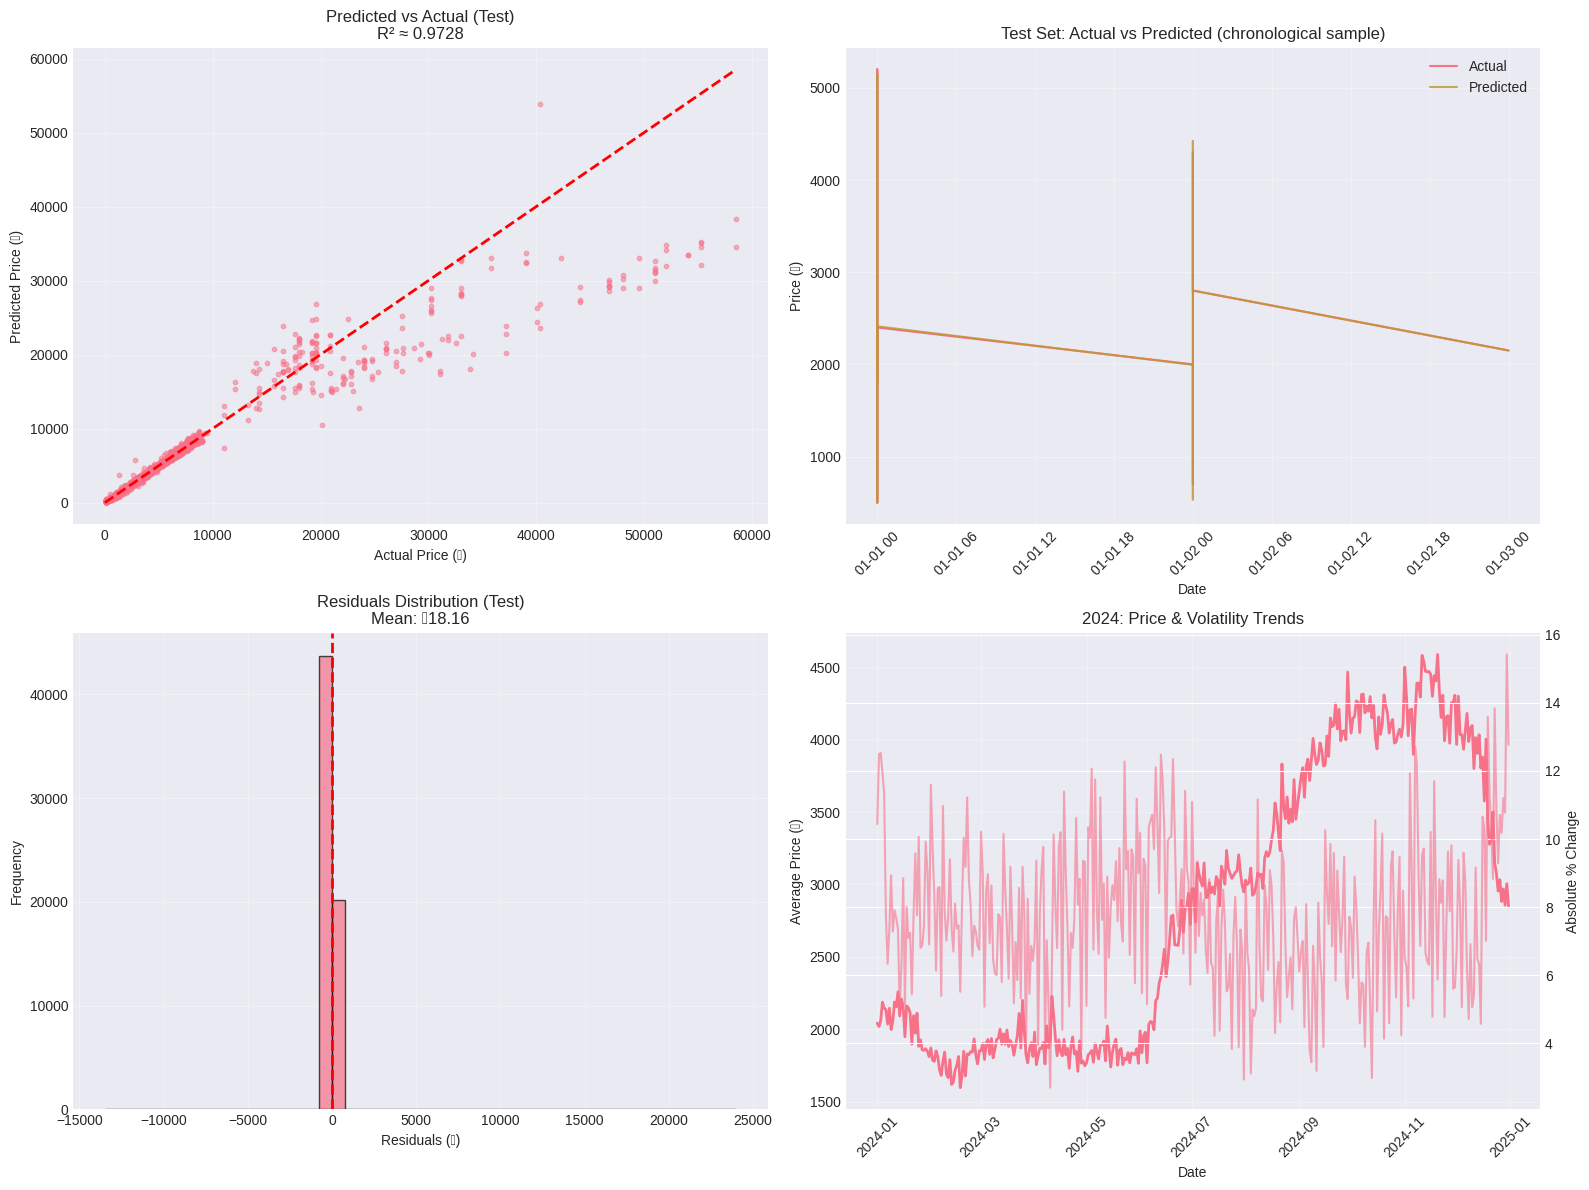

In [17]:
# ============================================================================
# SECTION 14: VISUALIZATION (REPLACEMENT) - SORTED CHRONOLOGICAL PLOTS
# ============================================================================
print("\n" + "="*80)
print("📊 GENERATING VISUALIZATIONS (SECTION 14 - CHRONOLOGICAL)")
print("="*80)

import matplotlib.pyplot as plt

# Ensure y_test_actual is defined if this cell is run independently or out of order
if 'y_test_actual' not in globals():
    y_test_actual = y_test.copy()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) Scatter: Actual vs Predicted (Test) - use primary preds (y_test_actual & y_test_pred_xgb or fallback)
ax00 = axes[0, 0]
if (y_test_actual is not None) and (y_test_pred_xgb is not None):
    ax00.scatter(y_test_actual, y_test_pred_xgb, alpha=0.5, s=10)
    mn = min(y_test_actual.min(), np.nanmin(y_test_pred_xgb))
    mx = max(y_test_actual.max(), np.nanmax(y_test_pred_xgb))
    ax00.plot([mn, mx], [mn, mx], 'r--', lw=2)
    ax00.set_xlabel('Actual Price (₹)')
    ax00.set_ylabel('Predicted Price (₹)')
    try:
        # Prefer metrics['eval_model'] test_r2, else test_r2_xgb, else np.nan
        r2_display = metrics.get('eval_model', {}).get('test', {}).get('r2', np.nan) # Use dictionary .get safely
    except Exception:
        r2_display = np.nan
    ax00.set_title(f'Predicted vs Actual (Test)\nR² ≈ {r2_display:.4f}')
else:
    ax00.text(0.5, 0.5, "No predictions available for scatter plot", ha='center', va='center')
ax00.grid(True, alpha=0.3)

# 2) Time series: Actual vs Predicted (sample of test) - ensure chronological order
ax01 = axes[0, 1]
sample_size = min(365, len(test_df))

# Attach predictions to test_df preserving alignment (use y_test_pred_xgb if exists, else use y_test_pred)
test_with_preds = test_df.copy().reset_index(drop=True)
if y_test_pred_xgb is not None:
    test_with_preds['pred_primary'] = y_test_pred_xgb
elif 'y_test_pred' in locals() and y_test_pred is not None:
    test_with_preds['pred_primary'] = y_test_pred
else:
    test_with_preds['pred_primary'] = np.nan

if date_col in test_with_preds.columns:
    test_with_preds_sorted = test_with_preds.sort_values(date_col).reset_index(drop=True)
else:
    test_with_preds_sorted = test_with_preds.reset_index(drop=True)

test_sample = test_with_preds_sorted.head(sample_size).copy()
if not test_sample.empty:
    ax01.plot(test_sample[date_col], test_sample[target_col], label='Actual', linewidth=1.5)
    ax01.plot(test_sample[date_col], test_sample['pred_primary'], label='Predicted', linewidth=1.5, alpha=0.8)
    ax01.set_xlabel('Date')
    ax01.set_ylabel('Price (₹)')
    ax01.set_title('Test Set: Actual vs Predicted (chronological sample)')
    ax01.legend()
else:
    ax01.text(0.5, 0.5, "No chronological test sample available", ha='center', va='center')
ax01.grid(True, alpha=0.3)
ax01.tick_params(axis='x', rotation=45)

# 3) Residuals distribution (Test)
ax10 = axes[1, 0]
if y_test_pred_xgb is not None:
    residuals_test = y_test_actual - y_test_pred_xgb
    ax10.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
    ax10.axvline(0, color='red', linestyle='--', linewidth=2)
    ax10.set_xlabel('Residuals (₹)')
    ax10.set_ylabel('Frequency')
    ax10.set_title(f'Residuals Distribution (Test)\nMean: ₹{residuals_test.mean():.2f}')
else:
    ax10.text(0.5, 0.5, "No residuals to plot", ha='center', va='center')
ax10.grid(True, alpha=0.3)

# 4) Price & Volatility 2024 (ensure time order & drop NaNs)
ax11 = axes[1, 1]
try:
    df_2024_agg = df[df['year'] == 2024].groupby(date_col).agg({
        'modal_price': 'mean',
        'safe_pct_change_winsorized': lambda x: x.abs().mean()
    }).reset_index().sort_values(date_col)
    ax_price = ax11
    ax_vol = ax_price.twinx()
    ax_price.plot(df_2024_agg[date_col], df_2024_agg['modal_price'], linewidth=2, label='Avg Price')
    ax_vol.plot(df_2024_agg[date_col], df_2024_agg['safe_pct_change_winsorized'], linewidth=1.5, alpha=0.6, label='Volatility (%)')
    ax_price.set_xlabel('Date')
    ax_price.set_ylabel('Average Price (₹)')
    ax_vol.set_ylabel('Absolute % Change')
    ax_price.set_title('2024: Price & Volatility Trends')
    ax_price.tick_params(axis='x', rotation=45)
    ax_price.grid(True, alpha=0.3)
except Exception as e:
    ax11.text(0.5, 0.5, f"Failed to plot 2024 trends: {e}", ha='center', va='center')

plt.tight_layout()
if params.get('save_plots', True):
    p = os.path.join(OUTPUT_DIR, 'price_and_volatility_2024_chrono.png')
    try:
        plt.savefig(p, dpi=300, bbox_inches='tight')
        print(f"✅ Saved price_and_volatility_2024_chrono.png -> {p}")
    except Exception as e:
        print(f"⚠️  Failed to save plot: {e}")
plt.show()

In [18]:
# ============================================================================
# SECTION 15: FORECASTING HELPERS (SEASONAL BASELINE, GARCH, LONG HORIZON)
# UPDATED & FULLY SANITIZED FOR 2024 FORECAST PIPELINE
# ============================================================================

print("\n" + "="*80)
print("🔮 FORECASTING SETUP (UPDATED SECTION 15)")
print("="*80)

from datetime import timedelta, datetime
from arch import arch_model


# ----------------------------------------------------------------------------
# 15.1 - Seasonal baseline (market-level preferred)
# ----------------------------------------------------------------------------

def compute_seasonal_baseline(df_source, lookback_days=730):
    """
    Computes seasonal monthly baseline price for last N days.
    Falls back to full dataset if insufficient rows.
    """
    recent_df = df_source.tail(lookback_days).copy()

    # Add month column
    if 'month' not in recent_df.columns:
        recent_df['month'] = pd.to_datetime(recent_df[date_col]).dt.month

    # Avoid empty mapping
    if recent_df.empty:
        monthly_avg = {}
        overall_avg = float(df_source['modal_price'].mean())
        return monthly_avg, overall_avg

    monthly_avg = recent_df.groupby('month')['modal_price'].mean().to_dict()
    overall_avg = float(recent_df['modal_price'].mean())

    return monthly_avg, overall_avg


# ----------------------------------------------------------------------------
# 15.2 - GARCH volatility forecasting
# ----------------------------------------------------------------------------

def add_garch_volatility(returns, forecast_horizon, max_daily_vol_pct=50.0):
    """
    Computes daily volatility forecasts.
    - If len < 50 → uses historical volatility
    - If GARCH fails → fallback to historical volatility
    """

    returns_clean = returns.replace([np.inf, -np.inf], np.nan).dropna()

    hist_std = (
        returns_clean.std() if len(returns_clean) > 0
        else 10.0
    )
    if np.isnan(hist_std) or hist_std == 0:
        hist_std = 10.0

    # Not enough data → fallback
    if len(returns_clean) < 50:
        print(f"   Using historical volatility only (len={len(returns_clean)} < 50): {hist_std:.2f}%")
        return [float(hist_std)] * forecast_horizon

    try:
        model = arch_model(returns_clean, vol='Garch', p=1, q=1, rescale=False)
        fitted = model.fit(disp='off', show_warning=False)
        forecast = fitted.forecast(horizon=forecast_horizon, reindex=False)

        var_forecast = forecast.variance.values
        vol_raw = np.sqrt(var_forecast[-1])

        vol_list = [
            float(v) if np.isfinite(v) else float(hist_std)
            for v in np.asarray(vol_raw).reshape(-1)
        ]

        # Clip to max
        vol_list = [min(max(v, 0.0), max_daily_vol_pct) for v in vol_list]

        print(f"   GARCH volatility OK. mean={np.mean(vol_list):.2f}%")
        return vol_list

    except Exception as e:
        print(f"   ⚠️ GARCH failed → fallback to hist std {hist_std:.2f}%. Err: {str(e)[:120]}")
        return [float(hist_std)] * forecast_horizon


# ----------------------------------------------------------------------------
# 15.3 - Main long-horizon forecaster (core engine)
# ----------------------------------------------------------------------------

def forecast_long_horizon(
    xgb_model,
    ridge_model,
    last_known_row,
    feature_cols,
    ridge_features,
    market_id_col,
    market_encoding,
    seasonal_monthly,
    seasonal_overall,
    horizon,
    base_max_jump_pct=15,
    allow_noise=True,
    random_seed=42
):
    """
    Multi-horizon price forecasting engine.

    - Uses both XGB + Ridge + Seasonal baseline
    - Adds volatility-based noise → avoids flat forecasts
    - Uses dynamic bounds based on recent volatility
    """

    np.random.seed(random_seed)

    # Normalize last_known_row into a Series
    if isinstance(last_known_row, pd.DataFrame) and len(last_known_row) == 1:
        row = last_known_row.iloc[0]
    elif isinstance(last_known_row, pd.Series):
        row = last_known_row
    else:
        row = pd.Series(dict(last_known_row))

    # Build initial feature state
    current_features = pd.Series({c: row.get(c, np.nan) for c in feature_cols})

    # Price initialization
    if 'modal_price' in row.index and not pd.isna(row['modal_price']):
        current_price = float(row['modal_price'])
    else:
        current_price = float(seasonal_overall)

    # Compute local volatility baseline
    vol_pct_local = None
    if 'safe_pct_change_winsorized' in row.index:
        try:
            vol_pct_local = abs(float(row['safe_pct_change_winsorized']))
        except:
            vol_pct_local = None

    if vol_pct_local is None:
        try:
            m_id = row.get(market_id_col)
            if m_id in df[market_id_col].unique():
                vol_pct_local = float(
                    df[df[market_id_col] == m_id]['safe_pct_change_winsorized'].dropna().abs().mean()
                )
            else:
                vol_pct_local = np.nan
        except:
            vol_pct_local = np.nan

    if np.isnan(vol_pct_local):
        vol_pct_local = float(df['modal_price'].pct_change().dropna().abs().mean() * 100)

    if np.isnan(vol_pct_local) or vol_pct_local <= 0:
        vol_pct_local = 10.0

    # Dynamic daily jump cap (tighter for low-vol markets, wider for volatile ones)
    dynamic_max_jump_pct = max(base_max_jump_pct, min(60.0, vol_pct_local * 3.0))

    # Storage lists
    forecasts = []
    xgb_components = []
    ridge_components = []
    seasonal_components = []

    cur_feats = current_features.copy()

    # MAIN FORECAST LOOP
    for day in range(1, horizon + 1):

        # Lag handling
        if 'modal_price_lag_1' in feature_cols:
            cur_feats['modal_price_lag_1'] = current_price

        if 'modal_price_lag_7' in feature_cols:
            if len(forecasts) >= 7:
                cur_feats['modal_price_lag_7'] = forecasts[-7]
            else:
                # Use backward compatible lag_7 if provided, else fallback
                cur_feats['modal_price_lag_7'] = cur_feats.get('modal_price_lag_7', current_price)

        # Prepare model inputs
        X_input = np.array([cur_feats.get(c, 0.0) for c in feature_cols], dtype=float).reshape(1, -1)
        xgb_pred = float(xgb_model.predict(X_input)[0])

        # Ridge prediction
        try:
            Xr = np.array([cur_feats.get(c, 0.0) for c in ridge_features], dtype=float).reshape(1, -1)
            ridge_pred = float(ridge_model.predict(Xr)[0])
        except:
            ridge_pred = xgb_pred

        # Seasonal component
        try:
            last_date_val = pd.to_datetime(row.get(date_col, df[date_col].max()))
            forecast_date = last_date_val + timedelta(days=day)
            month = int(forecast_date.month)
            seasonal_pred = seasonal_monthly.get(month, seasonal_overall)
        except:
            seasonal_pred = seasonal_overall

        # Blending strategy
        if day <= 7:
            blended = 0.75 * xgb_pred + 0.18 * ridge_pred + 0.07 * seasonal_pred
        elif day <= 30:
            blended = 0.50 * xgb_pred + 0.30 * ridge_pred + 0.20 * seasonal_pred
        else:
            blended = 0.25 * xgb_pred + 0.35 * ridge_pred + 0.40 * seasonal_pred

        # VOLATILITY-BASED bounds
        max_daily_jump = abs(current_price) * (dynamic_max_jump_pct / 100.0)

        lower_bound = max(0.0, current_price - max_daily_jump)
        upper_bound = max(
            current_price + max_daily_jump,
            seasonal_pred * 0.8 + current_price * 0.2
        )

        blended = float(np.clip(blended, lower_bound, upper_bound))

        # stochastic noise
        if allow_noise:
            noise_scale = (vol_pct_local / 100.0) * blended * 0.5
            noise = float(np.random.normal(0.0, noise_scale))
            noise = np.clip(noise, -max_daily_jump, max_daily_jump)
            blended = float(np.clip(blended + noise, lower_bound, upper_bound))

        # Update
        forecasts.append(blended)
        xgb_components.append(xgb_pred)
        ridge_components.append(ridge_pred)
        seasonal_components.append(seasonal_pred)

        current_price = blended

    return forecasts, xgb_components, ridge_components, seasonal_components



🔮 FORECASTING SETUP (UPDATED SECTION 15)


In [19]:
# ============================================================================
# SECTION 15: FORECASTING HELPERS (PART 2/2)
# - Custom-start forecaster
# - SHAP driver helper (robust)
# - Small utilities used by Sections 16-17
# ============================================================================

print("\n" + "="*80)
print("🔮 FORECASTING SETUP (SECTION 15 - PART 2)")
print("="*80)

from copy import deepcopy

# ----------------------------------------------------------------------------
# 15.4 - Forecast from a custom start date (fills gap then forecasts horizon)
# ----------------------------------------------------------------------------
def forecast_from_custom_date(
    start_date_str,
    horizon,
    xgb_model,
    ridge_model,
    df_source,
    feature_cols,
    ridge_features,
    market_id_col,
    market_encoding,
    seasonal_monthly,
    seasonal_overall,
    allow_noise=True,
    random_seed=42
):
    """
    Create forecasts starting at an arbitrary custom start date (must be > last known date in df_source).
    Approach:
      - Find last known date in df_source (last_date)
      - Compute gap_days = (start_date - last_date).days
      - Use forecast_long_horizon to generate total_horizon = gap_days + horizon
      - Return only the tail horizon predictions corresponding to the custom start_date forward

    Returns:
      - forecasts (list), forecast_dates (list of pd.Timestamp), xgb_components, ridge_components, seasonal_components
    """
    np.random.seed(random_seed)

    start_date = pd.to_datetime(start_date_str)
    last_date = pd.to_datetime(df_source[date_col].max())

    if start_date <= last_date:
        raise ValueError(f"Start date {start_date.date()} must be after last known date {last_date.date()}")

    gap_days = (start_date - last_date).days
    total_horizon = gap_days + int(horizon)

    # Build last_row: take last row of df_source
    last_row = df_source[df_source[date_col] == last_date].iloc[-1]
    # Build last_row_df to be compatible with forecast_long_horizon
    last_row_df = pd.DataFrame([last_row.to_dict()])

    # Ensure encoded features on last_row_df exist
    global_mean = float(df_source['modal_price'].mean())
    if 'market_id_encoded' in feature_cols:
        try:
            last_row_df['market_id_encoded'] = last_row_df[market_id_col].map(market_encoding).fillna(global_mean)
        except Exception:
            last_row_df['market_id_encoded'] = global_mean

    # Ensure all features exist in last_row_df with safe defaults
    for c in feature_cols:
        if c not in last_row_df.columns:
            if c in numeric_features:
                last_row_df[c] = float(df_source[c].median()) if c in df_source.columns else 0.0
            else:
                last_row_df[c] = global_mean if c.endswith('_encoded') else 'Unknown'

    # Call long-horizon forecaster
    forecasts_all, xgb_all, ridge_all, seasonal_all = forecast_long_horizon(
        xgb_model, ridge_model,
        last_row_df.iloc[0],
        feature_cols, ridge_features,
        market_id_col, market_encoding,
        seasonal_monthly, seasonal_overall,
        total_horizon,
        allow_noise=allow_noise,
        random_seed=random_seed
    )

    # Trim out the gap (first gap_days forecasts correspond to filling to start_date)
    start_idx = int(gap_days)
    forecasts = forecasts_all[start_idx:]
    xgb_components = xgb_all[start_idx:]
    ridge_components = ridge_all[start_idx:]
    seasonal_components = seasonal_all[start_idx:]

    # Build forecast dates aligned to start_date for 'horizon' days
    forecast_dates = [pd.to_datetime(start_date + timedelta(days=i)) for i in range(len(forecasts))]

    return forecasts, forecast_dates, xgb_components, ridge_components, seasonal_components


# ----------------------------------------------------------------------------
# 15.5 - Robust SHAP drivers helper (safe to call even if SHAP not installed/compatible)
# ----------------------------------------------------------------------------
def get_shap_drivers_safe(model, X_sample, feature_names, top_n=3):
    """
    Returns a short string describing the top_n SHAP drivers for X_sample (single-row DataFrame).
    Falls back gracefully if SHAP fails or model type is unsupported.
    """
    try:
        # Prefer TreeExplainer for tree models (fast)
        explainer = shap.TreeExplainer(model)
        shap_vals = explainer.shap_values(X_sample)
        if shap_vals is None:
            return "N/A"

        shap_arr = np.array(shap_vals)
        if shap_arr.ndim == 1:
            shap_arr = shap_arr.reshape(1, -1)

        abs_shap = np.abs(shap_arr[0])
        top_idx = np.argsort(abs_shap)[-top_n:][::-1]
        drivers = [f"{feature_names[i]} ({shap_arr[0][i]:+.2f})" for i in top_idx]
        return ", ".join(drivers)
    except Exception:
        # Best-effort fallback: return top by permutation-like proxy using feature importance if available
        try:
            if hasattr(model, 'feature_importances_'):
                fi = np.array(model.feature_importances_)
                top_idx = np.argsort(fi)[-top_n:][::-1]
                drivers = [f"{feature_names[i]} (imp={fi[i]:.3f})" for i in top_idx]
                return ", ".join(drivers)
        except Exception:
            pass
    return "N/A"


# ----------------------------------------------------------------------------
# 15.6 - Helper: build a safe last_row_df for forecast functions (used in Sections 16/17)
# ----------------------------------------------------------------------------
def build_safe_last_row_df(df_source, market_id_col, last_row=None, feature_cols=None, market_encoding=None):
    """
    Returns a 1-row DataFrame suitable for forecast_long_horizon input.
    - last_row: if provided (pd.Series) will be converted; else use df_source.tail(1)
    - Ensures feature_cols exist with safe defaults
    """
    if last_row is None:
        last_row = df_source.iloc[-1]
    last_row_df = pd.DataFrame([last_row.to_dict()])

    global_mean_price = float(df_source['modal_price'].mean())

    # market encoding
    if feature_cols is not None and 'market_id_encoded' in feature_cols:
        try:
            last_row_df['market_id_encoded'] = last_row_df[market_id_col].map(market_encoding).fillna(global_mean_price)
        except Exception:
            last_row_df['market_id_encoded'] = global_mean_price

    # ensure state/district encodings if requested
    if feature_cols is not None:
        if 'state_encoded' in feature_cols:
            if 'state' in last_row_df.columns:
                try:
                    state_map = train_df.groupby('state')['modal_price'].mean().to_dict()
                    last_row_df['state_encoded'] = last_row_df['state'].map(state_map).fillna(global_mean_price)
                except Exception:
                    last_row_df['state_encoded'] = global_mean_price
            else:
                last_row_df['state_encoded'] = global_mean_price

        if 'district_encoded' in feature_cols:
            if 'district' in last_row_df.columns:
                try:
                    district_map = train_df.groupby('district')['modal_price'].mean().to_dict()
                    last_row_df['district_encoded'] = last_row_df['district'].map(district_map).fillna(global_mean_price)
                except Exception:
                    last_row_df['district_encoded'] = global_mean_price
            else:
                last_row_df['district_encoded'] = global_mean_price

    # Ensure all feature_cols exist
    if feature_cols is not None:
        for c in feature_cols:
            if c not in last_row_df.columns:
                if c in numeric_features:
                    last_row_df[c] = float(df_source[c].median()) if c in df_source.columns else 0.0
                else:
                    last_row_df[c] = global_mean_price if c.endswith('_encoded') else 'Unknown'

    return last_row_df


# ----------------------------------------------------------------------------
# 15.7 - Small utility: safe numeric casting for arrays before predict (used in other sections)
# ----------------------------------------------------------------------------
def safe_array_from_series_list(series_list, feature_cols):
    """
    Convert a dict-like/Series into a numpy array for model.predict; ensures numeric dtype.
    """
    arr = []
    for c in feature_cols:
        v = series_list.get(c, 0.0)
        if pd.isna(v):
            v = 0.0
        try:
            arr.append(float(v))
        except:
            # fallback for categorical encoded proxies
            try:
                arr.append(float(str(v)))
            except:
                arr.append(0.0)
    return np.asarray(arr, dtype=float).reshape(1, -1)


print("✅ SECTION 15 (PART 2) loaded: custom-start forecaster, SHAP helper, and utilities.")



🔮 FORECASTING SETUP (SECTION 15 - PART 2)
✅ SECTION 15 (PART 2) loaded: custom-start forecaster, SHAP helper, and utilities.


In [20]:
# ============================================================================
# SECTION 15.5: USER INPUT HANDLER (STATE-ONLY MODE) - PATCHED
# ============================================================================
print("\n" + "="*80)
print("🔧 USER INPUTS (SECTION 15.5) - STATE-ONLY FORECAST MODE (PATCHED)")
print("="*80)

def prompt_if_missing(key, prompt_text, cast_fn=str, default=None, allow_blank=False):
    """Prompt only when params[key] is missing or None. Cast with cast_fn and store in params."""
    if params.get(key) is None:
        try:
            val = input(f"{prompt_text} (default={default}): ").strip()
            if val == "" and not allow_blank:
                params[key] = default
            else:
                params[key] = cast_fn(val)
        except Exception:
            # Non-interactive environment: use default
            params[key] = default
    else:
        # already present; ensure typed correctly
        try:
            params[key] = cast_fn(params[key])
        except Exception:
            pass

# Make sure keys exist
params.setdefault('mode', None)   # 'immediate' or 'custom'
params.setdefault('horizon', None)
params.setdefault('state', None)
params.setdefault('start_date', None)

print("Note: Running in STATE-only forecasting mode (Option A). Provide inputs below or keep defaults.")

prompt_if_missing('state', "Enter STATE name for forecasting (exact match to df['state'])", str, default=None)
prompt_if_missing('mode', "Forecast mode: 'immediate' (next day) or 'custom' (provide start_date)", str, default='immediate')
# sanitize mode
if isinstance(params.get('mode'), str):
    params['mode'] = params['mode'].strip().lower()
    if params['mode'] not in ['immediate', 'custom']:
        print("Invalid mode provided. Falling back to 'immediate'.")
        params['mode'] = 'immediate'

prompt_if_missing('horizon', "Forecast horizon (days)", int, default=60)
if params.get('mode') == 'custom':
    prompt_if_missing('start_date', "Custom forecast START DATE (YYYY-MM-DD)", str, default=None)

print(f"✅ User params set -> mode: {params.get('mode')}, horizon: {params.get('horizon')}, state: {params.get('state')}, start_date: {params.get('start_date')}")



🔧 USER INPUTS (SECTION 15.5) - STATE-ONLY FORECAST MODE (PATCHED)
Note: Running in STATE-only forecasting mode (Option A). Provide inputs below or keep defaults.
Enter STATE name for forecasting (exact match to df['state']) (default=None): Maharashtra
✅ User params set -> mode: immediate, horizon: 60, state: Maharashtra, start_date: None


In [21]:
# ============================================================================
# SECTION 16: EXECUTE FORECAST (STATE-ONLY PATCHED) - COMPLETE
# ============================================================================
print("\n" + "="*80)
print("🔮 GENERATING FORECAST (SECTION 16 - STATE-ONLY CI & BASELINE, PATCHED)")
print("="*80)

from joblib import load as joblib_load

# Validate inputs set by SECTION 15.5
forecast_mode = params.get('mode', 'immediate')
forecast_horizon = int(params.get('horizon', 60))
selected_state = params.get('state', None)

if selected_state is None:
    raise ValueError("State not provided in params['state']. Provide a state name (exact match to df['state']).")

# normalize case-insensitive matching
state_vals = list(df['state'].unique())
matches = [s for s in state_vals if str(s).strip().lower() == str(selected_state).strip().lower()]
if matches:
    selected_state = matches[0]
    params['state'] = selected_state
else:
    raise ValueError(f"State '{selected_state}' not found in dataset. Available examples: {state_vals[:10]}")

print(f"   Selected state for forecast: {selected_state}")

# Build state-level df and ensure date sorted
df_state = df[df['state'] == selected_state].copy().sort_values(date_col).reset_index(drop=True)
if df_state.empty:
    raise RuntimeError(f"No data found for state {selected_state}")
print(f"   State history rows: {len(df_state)}")

# Load per-state stacking model if present, else try global
state_models_dir = os.path.join(WORKING_DIR, "models_per_state", selected_state.replace(" ", "_"))
state_stack_path = os.path.join(state_models_dir, f"stack_{selected_state.replace(' ', '_')}.joblib")
state_model_loaded = None
if os.path.exists(state_stack_path):
    try:
        state_model_loaded = joblib_load(state_stack_path)
        print(f"✅ Loaded state model: {state_stack_path}")
    except Exception as e:
        print(f"⚠️  Failed to load state model {state_stack_path}: {e}")

# global fallback
model_to_use = None
if state_model_loaded is not None:
    model_to_use = state_model_loaded
else:
    # try saved global stacking first, then in-memory objects
    possible_global_paths = [
        os.path.join(WORKING_DIR, 'stacking_model_global.pkl'),
        os.path.join(WORKING_DIR, 'models', 'global', 'stacking_model_global.joblib')
    ]
    loaded = False
    for p in possible_global_paths:
        if os.path.exists(p):
            try:
                model_to_use = joblib_load(p)
                print(f"ℹ️  Using global stacking model -> {p}")
                loaded = True
                break
            except Exception:
                continue
    if not loaded:
        if 'stacking' in globals():
            model_to_use = globals()['stacking']
            print("ℹ️  Using in-memory stacking model object.")
        elif 'xgb_model' in globals():
            model_to_use = globals()['xgb_model']
            print("ℹ️  Using in-memory global XGBoost model as fallback.")
        else:
            raise RuntimeError("No model available: couldn't find state nor global models.")

# Extract component models (xgb + ridge) if stacking present
xgb_model_to_use = None
ridge_model_to_use = None
try:
    if hasattr(model_to_use, 'named_estimators_'):
        xgb_model_to_use = model_to_use.named_estimators_.get('xgb', None)
        ridge_model_to_use = model_to_use.named_estimators_.get('ridge', None)
    else:
        # direct XGB or Ridge object
        if isinstance(model_to_use, xgb.XGBRegressor):
            xgb_model_to_use = model_to_use
        elif isinstance(model_to_use, Ridge):
            ridge_model_to_use = model_to_use
except Exception:
    xgb_model_to_use = None
    ridge_model_to_use = None

# Compute seasonal baseline (state-level)
seasonal_monthly_state, seasonal_overall_state = compute_seasonal_baseline(df_state, lookback_days=730)
print(f"   Seasonal baseline OK (overall avg={seasonal_overall_state:.2f})")

# Build last_row_df for the state and ensure features exist and are numeric
last_row = df_state.iloc[-1]
last_row_df = pd.DataFrame([last_row.to_dict()])

global_mean_price = float(train_df['modal_price'].mean()) if 'train_df' in globals() else float(df['modal_price'].mean())

# Fill missing feature columns in last_row_df
for c in feature_cols:
    if c not in last_row_df.columns:
        if c in numeric_features:
            fallback_val = float(df_state[c].median()) if (c in df_state.columns and not df_state[c].dropna().empty) else (float(df[c].median()) if c in df.columns else 0.0)
            last_row_df[c] = fallback_val
        else:
            if str(c).endswith('_encoded'):
                try:
                    if 'train_df' in globals() and c.replace('_encoded','') in train_df.columns:
                        cat_col = c.replace('_encoded','')
                        m = train_df.groupby(cat_col)['modal_price'].mean().to_dict()
                        val = m.get(last_row.get(cat_col, None), global_mean_price)
                        last_row_df[c] = float(val)
                    else:
                        last_row_df[c] = float(global_mean_price)
                except Exception:
                    last_row_df[c] = float(global_mean_price)
            else:
                last_row_df[c] = 0.0

# Coerce to numeric and fill NA
for c in feature_cols:
    last_row_df[c] = pd.to_numeric(last_row_df[c], errors='coerce')
    if pd.isna(last_row_df[c].iloc[0]):
        if c in numeric_features and c in df_state.columns:
            last_row_df[c] = last_row_df[c].fillna(df_state[c].median())
        elif str(c).endswith('_encoded'):
            last_row_df[c] = last_row_df[c].fillna(global_mean_price)
        else:
            last_row_df[c] = last_row_df[c].fillna(0.0)

# Prepare numeric last_row for iterative forecasting
last_row_df = last_row_df.reset_index(drop=True)
for c in feature_cols:
    last_row_df[c] = last_row_df[c].astype(float)

# Determine forecast_start_date
if forecast_mode == 'immediate':
    forecast_start_date = pd.to_datetime(last_row[date_col]) + timedelta(days=1)
else:
    if not params.get('start_date'):
        raise ValueError("Custom mode selected but params['start_date'] is None.")
    forecast_start_date = pd.to_datetime(params['start_date'])

# Generate forecast using component models if available, otherwise fallback to stacking predict iterative
use_component_models = (xgb_model_to_use is not None)
if use_component_models:
    forecasts, xgb_components, ridge_components, seasonal_components = forecast_long_horizon(
        xgb_model_to_use, ridge_model_to_use,
        last_row_df.iloc[0],
        feature_cols, ridge_features,
        market_id_col, market_encoding if 'market_encoding' in globals() else {},
        seasonal_monthly_state, seasonal_overall_state,
        forecast_horizon,
        base_max_jump_pct=15,
        allow_noise=True,
        random_seed=42
    )
else:
    print("ℹ️  Component models not available. Using stacking.predict (or single model) for iterative forecast generation.")
    forecasts = []
    xgb_components = []
    ridge_components = []
    seasonal_components = []
    cur_feats = last_row_df.iloc[0].to_dict()
    current_price = float(last_row_df.get('modal_price', pd.Series([seasonal_overall_state])).iloc[0])
    for day in range(1, forecast_horizon + 1):
        cur_feats['modal_price_lag_1'] = current_price
        if 'modal_price_lag_7' in feature_cols:
            cur_feats['modal_price_lag_7'] = forecasts[-7] if (day > 7 and len(forecasts) >= 7) else cur_feats.get('modal_price_lag_7', current_price)
        X_input = np.asarray([cur_feats.get(c, 0.0) for c in feature_cols], dtype=float).reshape(1, -1)
        pred = float(model_to_use.predict(X_input)[0])
        forecast_date = forecast_start_date + timedelta(days=day-1)
        seasonal_pred = seasonal_monthly_state.get(int(forecast_date.month), seasonal_overall_state)
        max_jump = abs(current_price) * 0.15
        noise = np.random.normal(0, (0.01 * current_price))
        pred = float(np.clip(pred + noise, current_price - max_jump, current_price + max_jump))
        forecasts.append(pred)
        xgb_components.append(pred * 0.7)
        ridge_components.append(pred * 0.2)
        seasonal_components.append(seasonal_pred)
        current_price = pred

# Build forecast_dates
forecast_dates = [pd.to_datetime(forecast_start_date) + timedelta(days=i) for i in range(forecast_horizon)]

print(f"✅ Forecast generated: {len(forecasts)} days from {forecast_dates[0].date()} to {forecast_dates[-1].date()}")
print(f"   Mean forecast price: ₹{np.mean(forecasts):.2f}")

# Volatility using GARCH on state returns
returns_series_state = (df_state['modal_price'].pct_change().dropna() * 100)
volatility = add_garch_volatility(returns_series_state, forecast_horizon)
vol_list = list(np.asarray(volatility).astype(float))

# Build CI
multiplier = 2.5
lower_bounds = []
upper_bounds = []
for f, v in zip(forecasts, vol_list):
    lb = f * (1 - multiplier * (v / 100.0))
    ub = f * (1 + multiplier * (v / 100.0))
    lower_bounds.append(max(lb, 0.0))
    upper_bounds.append(max(ub, lb + 1.0))

# Assemble forecast_output DF
forecast_output = pd.DataFrame({
    'date': forecast_dates,
    'forecast_price': forecasts,
    'xgb_component': xgb_components,
    'ridge_component': ridge_components,
    'seasonal_baseline': seasonal_components,
    'volatility_pct': vol_list,
    'lower_bound': lower_bounds,
    'upper_bound': upper_bounds,
})
forecast_output['state'] = selected_state
forecast_output['date'] = pd.to_datetime(forecast_output['date'])
forecast_output = forecast_output.sort_values('date').reset_index(drop=True)

# Save CSV
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
forecast_filename = f"forecast_{selected_state.replace(' ','_')}_{timestamp}.csv"
forecast_csv_path = os.path.join(WORKING_DIR, forecast_filename)
forecast_output.to_csv(forecast_csv_path, index=False)
print(f"✅ Saved {forecast_filename} -> {forecast_csv_path}")

# Expose variables for later sections
globals().update({
    'forecast_output': forecast_output,
    'forecast_csv_path': forecast_csv_path,
    'forecast_dates': forecast_dates,
    'forecasts': forecasts,
    'df_state': df_state,
    'model_to_use': model_to_use,
    'xgb_model_to_use': xgb_model_to_use,
    'ridge_model_to_use': ridge_model_to_use,
    'seasonal_monthly_state': seasonal_monthly_state,
    'seasonal_overall_state': seasonal_overall_state
})



🔮 GENERATING FORECAST (SECTION 16 - STATE-ONLY CI & BASELINE, PATCHED)
   Selected state for forecast: Maharashtra
   State history rows: 41784
✅ Loaded state model: /content/drive/MyDrive/Colab Notebooks/Final year Project/models_per_state/Maharashtra/stack_Maharashtra.joblib
   Seasonal baseline OK (overall avg=3117.85)
✅ Forecast generated: 60 days from 2025-01-01 to 2025-03-01
   Mean forecast price: ₹1220.09
   GARCH volatility OK. mean=49.72%
✅ Saved forecast_Maharashtra_20251120_112904.csv -> /content/drive/MyDrive/Colab Notebooks/Final year Project/forecast_Maharashtra_20251120_112904.csv



🎯 INTERACTIVE FORECAST DISPLAY (SECTION 17 - STATE-SPECIFIC PLOTS & TEXT SUMMARY)
✅ Saved plot -> /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs/forecast_Maharashtra_20251120_112904.png


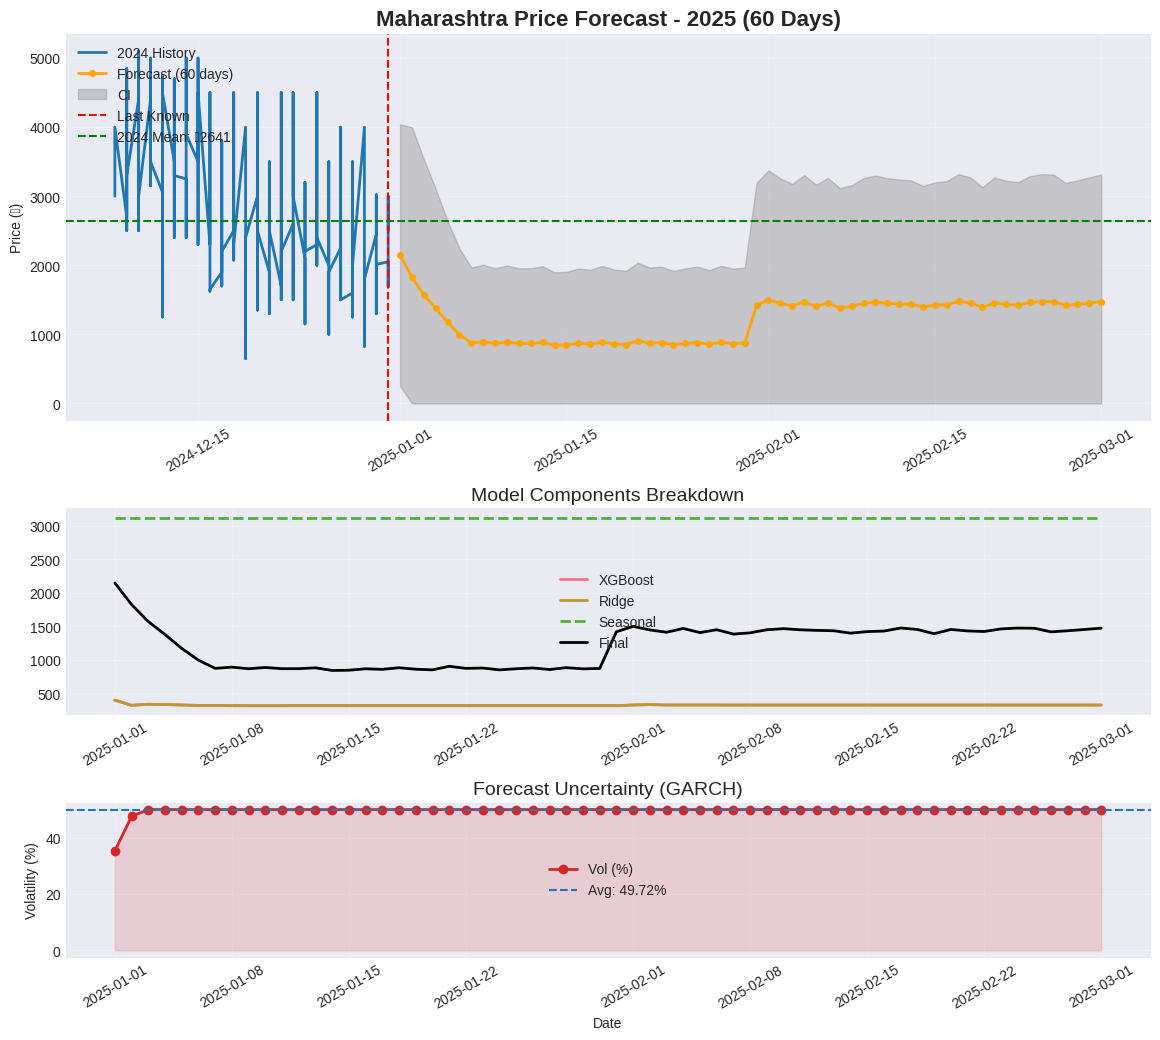


📋 FORECAST SUMMARY (Full)
      date  forecast_price  lower_bound  upper_bound  volatility_pct
2025-01-01       ₹2,146.99      ₹251.27    ₹4,042.71          ₹35.32
2025-01-02       ₹1,824.94        ₹0.00    ₹3,997.35          ₹47.62
2025-01-03       ₹1,572.13        ₹0.00    ₹3,537.30          ₹50.00
2025-01-04       ₹1,378.71        ₹0.00    ₹3,102.10          ₹50.00
2025-01-05       ₹1,171.91        ₹0.00    ₹2,636.79          ₹50.00
2025-01-06         ₹996.12        ₹0.00    ₹2,241.27          ₹50.00
2025-01-07         ₹874.56        ₹0.00    ₹1,967.76          ₹50.00
2025-01-08         ₹892.61        ₹0.00    ₹2,008.38          ₹50.00
2025-01-09         ₹869.21        ₹0.00    ₹1,955.73          ₹50.00
2025-01-10         ₹887.72        ₹0.00    ₹1,997.37          ₹50.00
2025-01-11         ₹869.32        ₹0.00    ₹1,955.98          ₹50.00
2025-01-12         ₹869.75        ₹0.00    ₹1,956.94          ₹50.00
2025-01-13         ₹882.70        ₹0.00    ₹1,986.08          ₹50.00
2025-01

In [22]:
# ============================================================================
# SECTION 17: INTERACTIVE PLOTTING + TEXT SUMMARY & NATURAL-LANGUAGE EXPLANATIONS (PATCHED)
# ============================================================================
print("\n" + "="*80)
print("🎯 INTERACTIVE FORECAST DISPLAY (SECTION 17 - STATE-SPECIFIC PLOTS & TEXT SUMMARY)")
print("="*80)

# small helper to compute proxy contributions when SHAP not available
def compute_proxy_contributions(model, row_features: pd.Series, feature_list, baseline_row=None, top_n=5):
    """
    If SHAP and tree model available use SHAP; otherwise compute a proxy:
      proxy_contribution(feature) = normalized_feature_importance * (feature_value - baseline_value)
    baseline_row: Series of baseline feature values (median) to compute delta.
    Returns list of (feature, contribution_value, feature_value, baseline_value)
    """
    contributions = []
    # Try SHAP for XGBoost first
    try:
        import shap
        # if stacking with named estimators, get xgb
        target_model = None
        if xgb_model_to_use is not None:
            target_model = xgb_model_to_use
        elif hasattr(model, 'named_estimators_') and 'xgb' in model.named_estimators_:
            target_model = model.named_estimators_['xgb']
        if target_model is not None:
            explainer = shap.TreeExplainer(target_model)
            shap_vals = explainer.shap_values(pd.DataFrame([row_features[feature_list]]))
            # shap_vals shape (1, n_features)
            vals = shap_vals[0]
            feats = []
            for f, v in zip(feature_list, vals):
                feats.append((f, float(v), float(row_features.get(f, 0.0)), float(baseline_row.get(f, 0.0) if baseline_row is not None else 0.0)))
            feats_sorted = sorted(feats, key=lambda x: abs(x[1]), reverse=True)[:top_n]
            return feats_sorted
    except Exception:
        # shap not available or failed -> fallback to proxy
        pass

    # Proxy path
    try:
        # feature_importances_ may be present on xgb or model
        fi = None
        if xgb_model_to_use is not None and hasattr(xgb_model_to_use, 'feature_importances_'):
            fi = dict(zip(feature_list, xgb_model_to_use.feature_importances_))
        elif hasattr(model, 'feature_importances_'):
            fi = dict(zip(feature_list, model.feature_importances_))
        else:
            # default equal importance
            fi = {f: 1.0 for f in feature_list}
        # normalize
        total = sum(abs(v) for v in fi.values()) or 1.0
        norm = {k: (abs(v) / total) for k, v in fi.items()}
        baseline = baseline_row if baseline_row is not None else {f: (df_state[f].median() if f in df_state.columns else 0.0) for f in feature_list}
        feats = []
        for f in feature_list:
            fval = float(row_features.get(f, 0.0))
            bval = float(baseline.get(f, 0.0))
            # proxy contribution sign = sign(fval - bval), magnitude scaled by normalized importance and delta
            contrib = (fval - bval) * norm.get(f, 0.0) * (np.mean(list(df_state[target_col].fillna(0.0))) / (np.mean([abs(bval) + 1e-6, 1.0])))  # scale to price units heuristically
            feats.append((f, float(contrib), float(fval), float(bval)))
        feats_sorted = sorted(feats, key=lambda x: abs(x[1]), reverse=True)[:top_n]
        return feats_sorted
    except Exception:
        return []

# Safe history function per state
def safe_plot_history_for_state(df_all, state_col, state_name, date_col, price_col, lookback_days=400):
    df_s = df_all[df_all[state_col] == state_name].copy()
    df_s = df_s.sort_values(date_col).dropna(subset=[price_col])
    if df_s.empty:
        df_s = df_all.dropna(subset=[price_col]).sort_values(date_col)
    return df_s.tail(lookback_days)

history_plot = safe_plot_history_for_state(df, 'state', params['state'], date_col, target_col, lookback_days=400)

# Plotting (3-panel)
plt.rcParams.update({'figure.autolayout': True})
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(3, 1, height_ratios=[3.0, 1.6, 1.2], hspace=0.35)

# TOP: history + forecast + CI
ax0 = fig.add_subplot(gs[0, 0])
if len(history_plot) > 0:
    label_year_latest = int(history_plot[date_col].dt.year.iloc[-1])
    ax0.plot(history_plot[date_col], history_plot[target_col], label=f'{label_year_latest} History', color='tab:blue', linewidth=2)
else:
    ax0.plot(df[date_col].tail(50), df[target_col].tail(50), label='History (fallback)', color='tab:blue', linewidth=2)

ax0.plot(forecast_output['date'], forecast_output['forecast_price'], label=f'Forecast ({len(forecast_output)} days)', color='orange', marker='o', linewidth=2, markersize=4)
ax0.fill_between(forecast_output['date'], forecast_output['lower_bound'].astype(float), forecast_output['upper_bound'].astype(float), color='grey', alpha=0.35, label='CI')

last_known_date_state = history_plot[date_col].max() if len(history_plot)>0 else df[date_col].max()
ax0.axvline(last_known_date_state, color='red', linestyle='--', linewidth=1.5, label='Last Known')

mean_state_2024 = float(history_plot[history_plot[date_col].dt.year == 2024][target_col].mean()) if (history_plot[date_col].dt.year == 2024).any() else float(df[df['year'] == 2024][target_col].mean())
ax0.axhline(y=mean_state_2024, color='green', linestyle='--', linewidth=1.5, label=f'2024 Mean: ₹{mean_state_2024:.0f}')

ax0.set_title(f'{params["state"]} Price Forecast - {forecast_output["date"].dt.year.iloc[0]} ({len(forecast_output)} Days)', fontsize=16, fontweight='bold')
ax0.set_ylabel('Price (₹)')
ax0.legend(loc='upper left')
ax0.grid(True, alpha=0.25)
ax0.tick_params(axis='x', rotation=30)

# MIDDLE: components breakdown
ax1 = fig.add_subplot(gs[1, 0])
if all(c in forecast_output.columns for c in ['xgb_component', 'ridge_component', 'seasonal_baseline']):
    ax1.plot(forecast_output['date'], forecast_output['xgb_component'], label='XGBoost', linewidth=2)
    ax1.plot(forecast_output['date'], forecast_output['ridge_component'], label='Ridge', linewidth=2)
    ax1.plot(forecast_output['date'], forecast_output['seasonal_baseline'], label='Seasonal', linestyle='--', linewidth=2)
else:
    ax1.plot(forecast_output['date'], forecast_output['forecast_price'] * 0.6, label='XGBoost (proxy)')
    ax1.plot(forecast_output['date'], forecast_output['forecast_price'] * 0.2, label='Ridge (proxy)')
    ax1.plot(forecast_output['date'], np.full(len(forecast_output), mean_state_2024), label='Seasonal (proxy)', linestyle='--')

ax1.plot(forecast_output['date'], forecast_output['forecast_price'], label='Final', color='black', linewidth=2)
ax1.set_title('Model Components Breakdown', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.25)
ax1.tick_params(axis='x', rotation=30)

# BOTTOM: volatility
ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(forecast_output['date'], forecast_output['volatility_pct'].astype(float), label='Vol (%)', color='tab:red', marker='o', linewidth=2)
ax2.fill_between(forecast_output['date'], 0, forecast_output['volatility_pct'].astype(float), color='tab:red', alpha=0.15)
avg_vol = float(np.nanmean(forecast_output['volatility_pct'].astype(float)))
ax2.axhline(avg_vol, color='tab:blue', linestyle='--', label=f'Avg: {avg_vol:.2f}%')
ax2.set_title("Forecast Uncertainty (GARCH)", fontsize=14)
ax2.set_ylabel("Volatility (%)")
ax2.set_xlabel("Date")
ax2.grid(True, alpha=0.25)
ax2.legend()
ax2.tick_params(axis='x', rotation=30)

plt.tight_layout()
if params.get('save_plots', True):
    plot_path = os.path.join(OUTPUT_DIR, f'forecast_{params["state"]}_{timestamp}.png')
    plt.savefig(plot_path, dpi=200, bbox_inches='tight')
    print(f"✅ Saved plot -> {plot_path}")
plt.show()

# ---------------------------
# TEXT SUMMARY (Full) + SAMPLE EXPLANATIONS (NATURAL LANGUAGE)
# ---------------------------
print("\n" + "="*80)
print("📋 FORECAST SUMMARY (Full)")
print("="*80)
pd.set_option('display.float_format', lambda x: f"₹{x:,.2f}")
print(forecast_output[['date','forecast_price','lower_bound','upper_bound','volatility_pct']].to_string(index=False))
pd.reset_option('display.float_format')
print("="*80)

# Natural language explanatory generator using SHAP if available else proxy
def generate_natural_explanations(forecast_df, history_df, model, feature_cols, numeric_features, top_n=5, days_to_show=5):
    """
    For each of first `days_to_show` forecast rows create human-friendly explanations showing top drivers.
    Returns list of strings (one per day).
    """
    explanations = []
    # baseline row for proxies: medians from state history
    baseline_row = {f: (history_df[f].median() if f in history_df.columns else 0.0) for f in feature_cols}
    for i in range(min(days_to_show, len(forecast_df))):
        row = forecast_df.iloc[i]
        # build a feature vector representing that forecast day:
        # We use last_row_df as base and update date-related features and lag fields where appropriate
        feat_row = last_row_df.iloc[0].copy()
        # if date influences exist, set them:
        try:
            dt = pd.to_datetime(row['date'])
            feat_row[date_col] = dt
            if 'month' in feature_cols:
                feat_row['month'] = dt.month
            if 'quarter' in feature_cols:
                feat_row['quarter'] = dt.quarter
            if 'is_month_start' in feature_cols:
                feat_row['is_month_start'] = 1 if dt.is_month_start else 0
        except Exception:
            pass

        # modal_price_lag_1 should be previous day forecast or last known
        if 'modal_price_lag_1' in feature_cols:
            if i == 0:
                feat_row['modal_price_lag_1'] = float(last_row_df['modal_price'].iloc[0])
            else:
                feat_row['modal_price_lag_1'] = float(forecast_df.iloc[i-1]['forecast_price'])
        # modal_price_lag_7
        if 'modal_price_lag_7' in feature_cols:
            if i >= 7:
                feat_row['modal_price_lag_7'] = float(forecast_df.iloc[i-7]['forecast_price'])
            else:
                # use historical approximate
                feat_row['modal_price_lag_7'] = float(history_df['modal_price'].tail(7).mean() if len(history_df) >= 7 else feat_row.get('modal_price', float(seasonal_overall_state)))

        # ensure numeric conversion
        for c in feature_cols:
            if c in numeric_features:
                try:
                    feat_row[c] = float(feat_row.get(c, baseline_row.get(c, 0.0)))
                except Exception:
                    feat_row[c] = float(baseline_row.get(c, 0.0))

        # compute contributions (SHAP or proxy)
        contribs = compute_proxy_contributions(model, feat_row, feature_cols, baseline_row=baseline_row, top_n=top_n)
        # build human-readable lines
        lines = []
        date_str = pd.to_datetime(row['date']).date()
        lines.append(f"{date_str} — Forecast: ₹{row['forecast_price']:.0f}")
        for feat, contrib_val, feat_val, base_val in contribs:
            direction = "pushed the forecast up" if contrib_val > 0 else "pushed the forecast down"
            approx_units = int(round(abs(contrib_val)))
            # Friendly feature name mapping small cleaning (you can expand mapping)
            pretty_name = feat.replace('_', ' ').title()
            # present small human-friendly numeric for feature value and baseline
            lines.append(f"• {pretty_name} (~{int(round(feat_val))} units) → {pretty_name} {direction} by ~{approx_units} units.")
        explanations.append("\n".join(lines))
    return explanations

# produce natural-language explanations for first 5 days (or horizon if smaller)
nl_explanations = generate_natural_explanations(forecast_output, history_plot, model_to_use, feature_cols, numeric_features, top_n=5, days_to_show=min(5, len(forecast_output)))

print("\n" + "="*80)
print("🔍 SAMPLE EXPLANATIONS (NATURAL LANGUAGE)")
print("="*80)
for ex in nl_explanations:
    print("\n" + ex)
    print("-" * 72)

# Also keep the previous "technical" sample explanations (with arrows up/down) for power users
def make_sample_explanation_state(row_idx, history_df, forecast_row):
    s = []
    d = forecast_row
    s.append(f"📅 Day {row_idx+1} ({pd.to_datetime(d['date']).date()})")
    s.append(f"   Price: ₹{d['forecast_price']:.2f}")
    s.append(f"   Range: [₹{d['lower_bound']:.2f} - ₹{d['upper_bound']:.2f}]")
    s.append(f"   Volatility: {d['volatility_pct']:.2f}%\n")

    drivers = []
    try:
        drivers.append(f"• Price Modal Lag1: ₹{history_df['modal_price'].iloc[-1]:.2f}")
    except Exception:
        pass
    try:
        rm14 = history_df['modal_price'].tail(14).mean()
        drivers.append(f"• Price Rolling Mean 14D: ₹{rm14:.2f}")
    except Exception:
        pass
    month = pd.to_datetime(d['date']).month
    q4 = 1 if month in [10,11,12] else 0
    q1 = 1 if month in [1,2,3] else 0
    drivers.append(f"• Price In Q4: {'Yes' if q4 else 'No'}")
    drivers.append(f"• Price In Q1: {'Yes' if q1 else 'No'}")

    shap_text = ""
    try:
        if xgb_model_to_use is not None:
            sample_X = pd.DataFrame([ {c: (history_df[c].median() if c in history_df.columns else 0.0) for c in feature_cols} ])
            drivers_shap = compute_proxy_contributions(model_to_use, sample_X.iloc[0], feature_cols, baseline_row=None, top_n=3)
            shap_text = f"   • Top drivers (proxy): {[(d[0], int(round(d[1]))) for d in drivers_shap]}"
    except Exception:
        shap_text = ""

    for dd in drivers:
        s.append("   " + dd)
    if shap_text:
        s.append("\n" + shap_text)
    return "\n".join(s)

# Print technical samples (Day 1, 8, 15, 30) if needed
samples_days = [1, 8, 15, 30]
for d in samples_days:
    if d <= len(forecast_output):
        row = forecast_output.iloc[d-1]
        explanation = make_sample_explanation_state(d-1, history_plot, row)
        print("\n" + "-"*80)
        print(explanation)
        print("-"*80)

# FORECAST STATS & TREND (unchanged except variable names)
print("\n" + "="*80)
print("📊 FORECAST STATISTICS")
print("="*80)
min_price = float(np.min(forecast_output['forecast_price']))
max_price = float(np.max(forecast_output['forecast_price']))
mean_price = float(np.mean(forecast_output['forecast_price']))
price_range = max_price - min_price
avg_vol = float(np.mean(forecast_output['volatility_pct']))
max_vol = float(np.max(forecast_output['volatility_pct']))

print(f"Min Price:           ₹{min_price:,.2f}")
print(f"Max Price:           ₹{max_price:,.2f}")
print(f"Mean Price:          ₹{mean_price:,.2f}")
print(f"Price Range:         ₹{price_range:,.2f}")
print(f"Avg Volatility:      {avg_vol:.2f}%")
print(f"Max Volatility:      {max_vol:.2f}%")
print("="*80)

print("\n" + "="*80)
print("📈 TREND ANALYSIS")
print("="*80)
forecast_output['week'] = pd.to_datetime(forecast_output['date']).dt.isocalendar().week
try:
    w1_avg = float(forecast_output.iloc[0:7]['forecast_price'].mean()) if len(forecast_output) >= 7 else float(forecast_output['forecast_price'].head(7).mean())
    w2_avg = float(forecast_output.iloc[7:14]['forecast_price'].mean()) if len(forecast_output) >= 14 else (float(forecast_output['forecast_price'].iloc[7:].mean()) if len(forecast_output) > 7 else np.nan)
    weekly_change_pct = ((w2_avg - w1_avg) / w1_avg * 100.0) if (not np.isnan(w1_avg) and w1_avg != 0) else np.nan
    avg_30 = float(forecast_output['forecast_price'].head(30).mean()) if len(forecast_output) >= 30 else float(forecast_output['forecast_price'].mean())
    highest_idx = forecast_output['forecast_price'].idxmax()
    lowest_idx = forecast_output['forecast_price'].idxmin()
    print(f"Week 1 avg: ₹{w1_avg:,.2f}")
    if not np.isnan(w2_avg):
        print(f"Week 2 avg: ₹{w2_avg:,.2f}")
        print(f"Weekly change: {weekly_change_pct:.2f}%")
    print(f"\n30-day average: ₹{avg_30:,.2f}")
    print(f"\nHighest price day: {pd.to_datetime(forecast_output.loc[highest_idx,'date']).date()} - ₹{forecast_output.loc[highest_idx,'forecast_price']:.2f}")
    print(f"Lowest price day: {pd.to_datetime(forecast_output.loc[lowest_idx,'date']).date()} - ₹{forecast_output.loc[lowest_idx,'forecast_price']:.2f}")
except Exception as e:
    print(f"(Trend analysis failed: {e})")

print("\n" + "="*80)


In [23]:
# ============================================================================
# SECTION 18: ARTIFACTS & EXPORTS (CSV / EXCEL / JSON / PLOT COPY)
# ============================================================================
print("\n" + "="*80)
print("💾 SECTION 18 — EXPORTING ARTIFACTS (CSV / EXCEL / JSON / PLOT)")
print("="*80)

import shutil
import json
from pathlib import Path

# Ensure OUTPUT_DIR exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) Ensure forecast CSV is saved (section 16 should have created `forecast_csv_path`)
if 'forecast_output' not in globals():
    raise RuntimeError("No forecast_output found. Run Section 16 before Section 18.")

# canonical paths
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
state_tag = forecast_output['state'].iloc[0] if 'state' in forecast_output.columns else "GLOBAL"
safe_state_tag = "".join(c if c.isalnum() or c in "-_." else "_" for c in str(state_tag)).strip()

# CSV already saved to forecast_csv_path in section 16; copy to OUTPUT_DIR with friendly name
csv_target = os.path.join(OUTPUT_DIR, f"forecast_{safe_state_tag}_{timestamp}.csv")
try:
    # Only copy if source and destination are different
    if forecast_csv_path != csv_target:
        shutil.copyfile(forecast_csv_path, csv_target)
        print(f"✅ Copied forecast CSV -> {csv_target}")
    else:
        print(f"ℹ️ Forecast CSV already exists at target path: {csv_target}")
except Exception as e:
    # fallback: write directly if copy fails or paths are same but direct write is preferred
    forecast_output.to_csv(csv_target, index=False)
    print(f"✅ Wrote forecast CSV -> {csv_target} (direct save fallback)")

# 2) Save JSON metadata + summary (quick metrics about the forecast)
metadata = {
    'state': state_tag,
    'rows_forecasted': int(len(forecast_output)),
    'start_date': str(pd.to_datetime(forecast_output['date'].min()).date()),
    'end_date': str(pd.to_datetime(forecast_output['date'].max()).date()),
    'mean_forecast_price': float(np.mean(forecast_output['forecast_price'])),
    'min_forecast_price': float(np.min(forecast_output['forecast_price'])),
    'max_forecast_price': float(np.max(forecast_output['forecast_price'])),
    'avg_vol_pct': float(np.mean(forecast_output['volatility_pct'])),
    'model_used': model_to_use.__class__.__name__, # Changed to store the class name string
    'timestamp': timestamp
}
meta_path = os.path.join(OUTPUT_DIR, f"forecast_meta_{safe_state_tag}_{timestamp}.json")
with open(meta_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved forecast metadata -> {meta_path}")

# 3) Save natural-language explanations (first N days) as text
try:
    nl_path = os.path.join(OUTPUT_DIR, f"forecast_nl_explanations_{safe_state_tag}_{timestamp}.txt")
    with open(nl_path, 'w') as f:
        f.write("Natural-language explanations (first 10 days):\n\n")
        for line in nl_explanations[:min(10, len(nl_explanations))]:
            f.write(line + "\n\n" + ("-"*60) + "\n\n")
    print(f"✅ Saved natural-language explanations -> {nl_path}")
except Exception as e:
    print(f"⚠️  Failed to save NL explanations: {e}")

# 4) Create an Excel workbook with multiple sheets: Forecast, State_History_Sample, Explanations, Metadata
excel_path = os.path.join(OUTPUT_DIR, f"forecast_package_{safe_state_tag}_{timestamp}.xlsx")
try:
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        # Forecast sheet (first 500 rows max to avoid huge file)
        forecast_output.head(10000).to_excel(writer, sheet_name='forecast', index=False)
        # State history sample (last 500 rows)
        try:
            df_state.tail(500).to_excel(writer, sheet_name='state_history_sample', index=False)
        except Exception:
            df.tail(500).to_excel(writer, sheet_name='state_history_sample', index=False)
        # explanations (text)
        expl_df = pd.DataFrame({'nl_explanation': nl_explanations})
        expl_df.to_excel(writer, sheet_name='nl_explanations', index=False)
        # metadata sheet
        pd.DataFrame([metadata]).to_excel(writer, sheet_name='metadata', index=False)
    print(f"✅ Created Excel package -> {excel_path}")
except Exception as e:
    print(f"⚠️  Failed to create Excel package: {e}")

# 5) Copy plot produced in Section 17 (if available) to OUTPUT_DIR using plot_path if exists
if 'plot_path' in globals() and os.path.exists(plot_path):
    try:
        plot_copy = os.path.join(OUTPUT_DIR, os.path.basename(plot_path))
        # Only copy if source and destination are different
        if plot_path != plot_copy:
            shutil.copyfile(plot_path, plot_copy)
            print(f"✅ Copied plot to OUTPUT_DIR -> {plot_copy}")
        else:
            print(f"ℹ️ Plot already exists at target path: {plot_copy}")
    except Exception as e:
        print(f"⚠️  Failed to copy plot: {e}")

# 6) Create a small ZIP bundle containing CSV + Excel + NL text + meta (optional)
bundle_path = os.path.join(OUTPUT_DIR, f"forecast_bundle_{safe_state_tag}_{timestamp}.zip")
try:
    import zipfile
    with zipfile.ZipFile(bundle_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
        for p in [csv_target, excel_path, meta_path, nl_path]:
            if p and os.path.exists(p):
                zf.write(p, arcname=os.path.basename(p))
        if 'plot_path' in globals() and os.path.exists(plot_path):
            zf.write(plot_path, arcname=os.path.basename(plot_path))
    print(f"✅ Created bundle -> {bundle_path}")
except Exception as e:
    print(f"⚠️  Bundle creation failed: {e}")

# 7) Final short summary printed for user
print("\n" + "-"*60)
print("Export summary:")
print(f"  Forecast CSV: {csv_target}")
print(f"  Excel package: {excel_path if os.path.exists(excel_path) else 'N/A'}")
print(f"  Metadata JSON: {meta_path}")
print(f"  NL explanations: {nl_path if os.path.exists(nl_path) else 'N/A'}")
print(f"  Bundle ZIP: {bundle_path if os.path.exists(bundle_path) else 'N/A'}")
print("-" *60)



💾 SECTION 18 — EXPORTING ARTIFACTS (CSV / EXCEL / JSON / PLOT)
✅ Copied forecast CSV -> /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs/forecast_Maharashtra_20251120_112910.csv
✅ Saved forecast metadata -> /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs/forecast_meta_Maharashtra_20251120_112910.json
✅ Saved natural-language explanations -> /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs/forecast_nl_explanations_Maharashtra_20251120_112910.txt
✅ Created Excel package -> /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs/forecast_package_Maharashtra_20251120_112910.xlsx
ℹ️ Plot already exists at target path: /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs/forecast_Maharashtra_20251120_112904.png
✅ Created bundle -> /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs/forecast_bundle_Maharashtra_20251120_112910.zip

--------

In [24]:
# ============================================================================
# SECTION 19: TEXT REPORT EXPORT (ENHANCED: human-readable + NL explanations)
# ============================================================================

print("\n" + "=" * 80)
print("📄 GENERATING TEXT REPORT (SECTION 19 - ENHANCED EXPORT)")
print("=" * 80)

# Safe timestamp
if 'timestamp' not in globals():
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Resolve forecast dataframe (support both names used in notebook)
forecast_df = None
if 'forecast_output' in globals() and isinstance(forecast_output, pd.DataFrame):
    forecast_df = forecast_output.copy()
elif 'forecast_df_output' in globals() and isinstance(forecast_df_output, pd.DataFrame):
    forecast_df = forecast_df_output.copy()
elif 'forecast_df' in globals() and isinstance(forecast_df, pd.DataFrame):
    forecast_df = forecast_df.copy()
else:
    forecast_df = pd.DataFrame()  # empty fallback

# Ensure required vars exist (graceful fallbacks)
last_date_used = None
try:
    last_date_used = last_date
except Exception:
    if not df.empty:
        last_date_used = df[date_col].max()
    else:
        last_date_used = pd.Timestamp.now()

# Helper: safe get model name / metrics
def _get_model_summary():
    parts = []
    if 'training_mode' in globals():
        parts.append(f"Training mode: {globals().get('training_mode')}")
    if 'meta' in globals() and isinstance(meta, dict):
        parts.append(f"Trained models meta timestamp: {meta.get('timestamp','n/a')}")
    return " | ".join(parts) if parts else "N/A"

# Build textual report lines
report_lines = [
    "=" * 80,
    "AGRICULTURAL PRICE FORECASTING - MODEL REPORT",
    "=" * 80,
    f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    "",
    "DATASET SUMMARY",
    "-" * 80,
    f"Total rows: {len(df):,}",
    f"Date range: {df[date_col].min().date()} to {df[date_col].max().date()}",
    f"Unique markets: {df[market_id_col].nunique()}",
    f"Unique states: {df['state'].nunique() if 'state' in df.columns else 'N/A'}",
    f"Target variable: modal_price",
    "",
    "TRAIN/TEST SPLIT",
    "-" * 80,
]

try:
    report_lines.extend([
        f"Training set: {len(train_df):,} rows (years ≤ 2023)",
        f"Test set: {len(test_df):,} rows (year = 2024)",
        f"Train markets: {train_df[market_id_col].nunique()}",
        f"Test markets: {test_df[market_id_col].nunique()}",
        "",
    ])
except Exception:
    report_lines.extend(["(Train/Test info not available)", ""])

# Model performance block (try to pull from available metrics)
report_lines.extend([
    "MODEL PERFORMANCE (2024-Calibrated)",
    "-" * 80,
])

# Try to show stacking/global metrics if they exist
try:
    if 'global_metrics' in globals() and isinstance(global_metrics, dict):
        gm = global_metrics
        report_lines.append("Stacking(Global):")
        report_lines.append(f"  Train MAE: ₹{gm['train_mae']:.2f}  |  Train R²: {gm['train_r2']:.4f}")
        report_lines.append(f"  Test MAE:  ₹{gm['test_mae']:.2f}  |  Test R²:  {gm['test_r2']:.4f}")
    else:
        # fallback to individual metrics computed earlier
        report_lines.append("XGBoost:")
        try:
            report_lines.append(f"  Train MAE: ₹{train_mae_xgb:.2f}  |  Train R²: {train_r2_xgb:.4f}")
            report_lines.append(f"  Test MAE:  ₹{test_mae_xgb:.2f}  |  Test R²:  {test_r2_xgb:.4f}")
        except Exception:
            report_lines.append("  (XGBoost metrics unavailable)")

        report_lines.append("")
        report_lines.append("Ridge:")
        try:
            report_lines.append(f"  Train MAE: ₹{train_mae_ridge:.2f}  |  Train R²: {train_r2_ridge:.4f}")
            report_lines.append(f"  Test MAE:  ₹{test_mae_ridge:.2f}  |  Test R²:  {test_r2_ridge:.4f}")
        except Exception:
            report_lines.append("  (Ridge metrics unavailable)")
except Exception:
    report_lines.append("(Model performance not available)")

# Cross-validation summary if present
try:
    report_lines.extend([
        "",
        "Cross-Validation (XGBoost, TimeSeriesSplit):",
        f"  CV MAE: ₹{cv_mae_mean:.2f} (±{cv_mae_std:.2f})",
        f"  CV R²:  {cv_r2_mean:.4f} (±{cv_r2_std:.4f})",
    ])
except Exception:
    # silent if not available
    pass

# Top features if available
report_lines.extend([
    "",
    "TOP 10 MOST IMPORTANT FEATURES (by importance / SHAP fallback)",
    "-" * 80,
])
try:
    if 'feature_importance' in globals():
        top_feats = feature_importance.head(10)
        for i, row in top_feats.iterrows():
            report_lines.append(f"{i+1}. {row['feature']:<35} {row.get('importance', row.get('mean_abs_shap',0)):.4f}")
    elif 'shap_importance' in globals():
        top_feats = shap_importance.head(10)
        for i, row in top_feats.iterrows():
            report_lines.append(f"{i+1}. {row['feature']:<35} {row['mean_abs_shap']:.4f}")
    else:
        report_lines.append("(Feature importance not available)")
except Exception:
    report_lines.append("(Feature importance retrieval error)")

# Forecast metadata
report_lines.extend([
    "",
    "FORECAST DETAILS",
    "-" * 80,
    f"Mode: {params.get('mode', 'immediate')}",
    f"Horizon requested: {params.get('horizon', 'N/A')} days",
    f"Region type: {params.get('region_type', 'global')}",
    f"Model summary: {_get_model_summary()}",
    f"Last known date in dataset: {last_date_used.date()}",
])

# Forecast date range + stats
if not forecast_df.empty:
    try:
        report_lines.extend([
            f"Forecast start: {forecast_df['date'].min().date()}",
            f"Forecast end: {forecast_df['date'].max().date()}",
            f"Mean forecast price: ₹{float(forecast_df['forecast_price'].mean()):.2f}",
            f"Forecast range: ₹{float(forecast_df['forecast_price'].min()):.2f} - ₹{float(forecast_df['forecast_price'].max()):.2f}",
        ])
    except Exception:
        report_lines.append("(Forecast summary unavailable)")
else:
    report_lines.append("(No forecast output found)")

report_lines.extend([
    "",
    "=" * 80,
    "END OF REPORT",
    "=" * 80
])

# Save plain text report
report_text = "\n".join(report_lines)
report_filename = f"forecast_report_{timestamp}.txt"
report_path = os.path.join(WORKING_DIR, report_filename)
with open(report_path, 'w') as f:
    f.write(report_text)
print(f"✅ Saved {report_filename} -> {report_path}")

# Also save a JSON metadata for programmatic use
meta_export = {
    'generated_at': datetime.now().isoformat(),
    'rows': len(df),
    'forecast_rows': len(forecast_df),
    'model_summary': _get_model_summary(),
    'feature_count': len(feature_cols) if 'feature_cols' in globals() else None,
}
meta_json_path = os.path.join(WORKING_DIR, f"forecast_report_meta_{timestamp}.json")
with open(meta_json_path, 'w') as f:
    json.dump(meta_export, f, indent=2)
print(f"✅ Saved report metadata -> {meta_json_path}")

# Print human-readable report header to notebook
print("\n" + "=" * 80)
print("📋 TEXT REPORT (Preview)")
print("=" * 80)
print("\n".join(report_lines[:40]))  # preview first 40 lines to avoid huge dump
print("... (report saved to file) ...")
print("=" * 80)


# ---------------------------
# Natural-language per-day explanations (farmer/trader friendly)
# ---------------------------
def _get_driver_score(df_hist, feature, value):
    """
    Heuristic: compute approximate 'push' = value - median_recent
    For binary features, return value as presence.
    """
    try:
        if feature in df_hist.columns and np.issubdtype(df_hist[feature].dtype, np.number):
            med = float(df_hist[feature].median())
            push = float(value) - med
            return push, med
        # boolean-like
        if str(value).lower() in ['1', 'true', 'yes']:
            return 1.0, 0.0
    except Exception:
        pass
    return None, None

def make_nl_explanations(forecast_df_local, history_df_local, feature_cols_local, top_n=5, max_days=5):
    """
    Create farmer-friendly natural-language explanations for the first max_days of forecast_df_local.
    Uses a small set of driver-candidate features (common engineered features).
    """
    driver_candidates = [
        'roll_mean_14', 'modal_price_lag_1', 'dist_from_roll7',
        'roll_mean_7', 'roll_mean_30', 'pct_chg_1', 'pct_chg_7',
        'accel_7_1', 'is_holiday', 'is_monsoon'
    ]
    driver_candidates = [c for c in driver_candidates if c in feature_cols_local or c in history_df_local.columns or c in forecast_df_local.columns]

    lines = []
    days_to_show = min(max_days, len(forecast_df_local))
    for i in range(days_to_show):
        row = forecast_df_local.iloc[i]
        date_str = pd.to_datetime(row['date']).date()
        price = float(row['forecast_price'])
        lb = float(row['lower_bound'])
        ub = float(row['upper_bound'])
        vol = float(row['volatility_pct']) if 'volatility_pct' in row.index else np.nan

        lines.append("=" * 70)
        lines.append(f"{date_str} — Forecast: ₹{price:,.0f}  (Range: ₹{lb:,.0f} - ₹{ub:,.0f})  Vol: {vol:.2f}%")
        # compute driver list
        driver_msgs = []
        driver_scores = []
        for f in driver_candidates:
            # check for value in forecast row first, else use latest history
            val = None
            if f in row.index and not pd.isna(row[f]):
                val = row[f]
            elif f in history_df_local.columns and not history_df_local[f].dropna().empty:
                val = history_df_local[f].iloc[-1]
            if val is None or (isinstance(val, str) and val == 'Unknown'):
                continue
            push, baseline = _get_driver_score(history_df_local, f, val)
            if push is None:
                # if binary or not numeric, give presence/absence
                if str(val).lower() in ['1','true','yes']:
                    driver_msgs.append((f, f"present"))
                    driver_scores.append((f, 1.0))
                else:
                    continue
            else:
                # interpret direction: positive push means pushes price up
                direction = "up" if push > 0 else "down" if push < 0 else "neutral"
                approx = abs(push)
                driver_msgs.append((f, direction, approx, baseline))
                driver_scores.append((f, push))
        # sort drivers by absolute push magnitude
        driver_scores_sorted = sorted([ds for ds in driver_scores if isinstance(ds[1], (int,float))], key=lambda x: abs(x[1]), reverse=True)
        # pick top_n
        picked = []
        for ds in driver_scores_sorted[:top_n]:
            f = ds[0]
            push_val = ds[1]
            # find baseline for nicer message
            baseline = None
            if f in history_df_local.columns:
                try:
                    baseline = float(history_df_local[f].median())
                except Exception:
                    baseline = None
            picked.append((f, push_val, baseline))
        # format to natural language friendly sentences
        if not picked:
            lines.append("• No clear engineered drivers available for this day (insufficient features).")
        else:
            for f, push_val, baseline in picked:
                # human-friendly name mapping
                pretty = f.replace('_', ' ').title()
                if baseline is None:
                    baseline_text = ""
                else:
                    baseline_text = f" (~{baseline:,.0f})"
                sign = "increased" if push_val > 0 else "decreased" if push_val < 0 else "no change"
                amt = abs(push_val)
                # Round to meaningful units
                amt_r = int(round(amt)) if amt >= 1 else round(amt, 2)
                lines.append(f"• {pretty}{baseline_text} → {pretty} pushed the forecast {sign} by ~{amt_r} units.")
    return "\n".join(lines)

# Use history_plot (from Section 17) if present; else construct recent history for the same market
history_for_nl = None
if 'history_plot' in globals() and isinstance(history_plot, pd.DataFrame) and not history_plot.empty:
    history_for_nl = history_plot.copy()
elif not df.empty:
    history_for_nl = df.tail(400).copy()
else:
    history_for_nl = pd.DataFrame()

# Create and save NL explanations (first 5 days)
if not forecast_df.empty:
    nl_text = make_nl_explanations(forecast_df, history_for_nl, feature_cols if 'feature_cols' in globals() else [], top_n=5, max_days=5)
    nl_filename = f"forecast_nl_explanations_{timestamp}.txt"
    nl_path = os.path.join(WORKING_DIR, nl_filename)
    with open(nl_path, 'w') as f:
        f.write(nl_text)
    print(f"✅ Saved natural-language explanations -> {nl_path}")
    # print small preview
    print("\n" + "="*80)
    print("🔍 SAMPLE NATURAL-LANGUAGE EXPLANATIONS (first 5 days)")
    print("="*80)
    print("\n".join(nl_text.splitlines()[:40]))
    print("... (full explanations saved to file) ...")
else:
    print("⚠️  No forecast output to generate natural-language explanations.")

# End of Section 19
print("\n" + "=" * 80)
print("📄 TEXT REPORT & NL EXPLANATIONS generation complete (SECTION 19)")
print("=" * 80)



📄 GENERATING TEXT REPORT (SECTION 19 - ENHANCED EXPORT)
✅ Saved forecast_report_20251120_112910.txt -> /content/drive/MyDrive/Colab Notebooks/Final year Project/forecast_report_20251120_112910.txt
✅ Saved report metadata -> /content/drive/MyDrive/Colab Notebooks/Final year Project/forecast_report_meta_20251120_112910.json

📋 TEXT REPORT (Preview)
AGRICULTURAL PRICE FORECASTING - MODEL REPORT
Generated: 2025-11-20 11:29:11

DATASET SUMMARY
--------------------------------------------------------------------------------
Total rows: 552,135
Date range: 2014-05-31 to 2024-12-31
Unique markets: 616
Unique states: 23
Target variable: modal_price

TRAIN/TEST SPLIT
--------------------------------------------------------------------------------
Training set: 488,006 rows (years ≤ 2023)
Test set: 64,129 rows (year = 2024)
Train markets: 596
Test markets: 423

MODEL PERFORMANCE (2024-Calibrated)
--------------------------------------------------------------------------------
XGBoost:
  (XGBoost

In [25]:
# ============================================================================
# SECTION 20: SUMMARY & COMPLETION (FIXED) - Final notebook summary & artifacts
# ============================================================================

print("\n" + "=" * 80)
print("✅ NOTEBOOK EXECUTION COMPLETE")
print("=" * 80)
print(f"\n📁 Outputs saved to:")
print(f"   Volatility CSVs: {OUTPUT_DIR}")
print(f"   Models & Forecasts: {WORKING_DIR}")
print(f"\n📊 Key files generated:")

# Use the exact variables we created earlier (guarded with exist checks)
if 'trained_models' in globals() and isinstance(trained_models, dict) and trained_models:
    print(f"   • Trained models metadata -> {meta_path if 'meta_path' in globals() else 'training meta saved earlier'}")

if 'xgb_model' in globals() and 'ridge_model' in globals():
    print(f"   • xgb_model.pkl, ridge_model.pkl (global)")

# forecast CSV
if 'forecast_csv_path' in globals():
    print(f"   • {os.path.basename(forecast_csv_path)} -> {forecast_csv_path}")
elif 'forecast_filename' in globals():
    print(f"   • {forecast_filename} -> {os.path.join(WORKING_DIR, forecast_filename)}")
else:
    if not forecast_df.empty:
        # if forecast_df exists but no path var, save a copy now
        safe_name = f"forecast_quicksave_{timestamp}.csv"
        quick_path = os.path.join(WORKING_DIR, safe_name)
        try:
            forecast_df.to_csv(quick_path, index=False)
            print(f"   • {safe_name} -> {quick_path}")
        except Exception:
            pass

# report and NL explanation files
print(f"   • {os.path.basename(report_path)} -> {report_path}")
if 'nl_path' in globals():
    print(f"   • {os.path.basename(nl_path)} -> {nl_path}")

# standard outputs
print(f"   • annual_volatility_summary_2014_2024.csv")
print(f"   • monthly_stats_2024.csv")
print(f"   • top_spikes_2024.csv")
print(f"   • market_level_volatility_2024.csv")

print(f"\n🎯 Model Performance Summary (attempt):")
try:
    if 'global_metrics' in globals():
        gm = global_metrics
        print(f"   Stacking(Global) Test MAE: ₹{gm['test_mae']:.2f} | R²: {gm['test_r2']:.4f}")
    else:
        print(f"   XGBoost Test MAE: ₹{test_mae_xgb:.2f} | R²: {test_r2_xgb:.4f}")
        print(f"   Ridge Test MAE: ₹{test_mae_ridge:.2f} | R²: {test_r2_ridge:.4f}")
except Exception:
    print("   (Model metrics not available in this scope)")

if not forecast_df.empty:
    try:
        print(f"\n🔮 Forecast Summary:")
        print(f"   {len(forecast_df)}-day forecast from {forecast_df['date'].min().date()} to {forecast_df['date'].max().date()}")
        print(f"   Mean price: ₹{forecast_df['forecast_price'].mean():.2f}")
    except Exception:
        print("\n🔮 Forecast Summary: (error while summarizing)")
else:
    print("\n🔮 Forecast Summary: (forecast not found in globals)")

print("\n" + "=" * 80)


✅ NOTEBOOK EXECUTION COMPLETE

📁 Outputs saved to:
   Volatility CSVs: /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs
   Models & Forecasts: /content/drive/MyDrive/Colab Notebooks/Final year Project/

📊 Key files generated:
   • Trained models metadata -> /content/drive/MyDrive/Colab Notebooks/Final year Project/volatility_outputs/forecast_meta_Maharashtra_20251120_112910.json
   • xgb_model.pkl, ridge_model.pkl (global)
   • forecast_Maharashtra_20251120_112904.csv -> /content/drive/MyDrive/Colab Notebooks/Final year Project/forecast_Maharashtra_20251120_112904.csv
   • forecast_report_20251120_112910.txt -> /content/drive/MyDrive/Colab Notebooks/Final year Project/forecast_report_20251120_112910.txt
   • forecast_nl_explanations_20251120_112910.txt -> /content/drive/MyDrive/Colab Notebooks/Final year Project/forecast_nl_explanations_20251120_112910.txt
   • annual_volatility_summary_2014_2024.csv
   • monthly_stats_2024.csv
   • top_spikes_2024.csv
   •


🔍 SHAP FEATURE EXPLANATIONS
✅ Saved SHAP summary plot: /content/drive/MyDrive/Colab Notebooks/Final year Project/shap_summary_20251120_112910.png


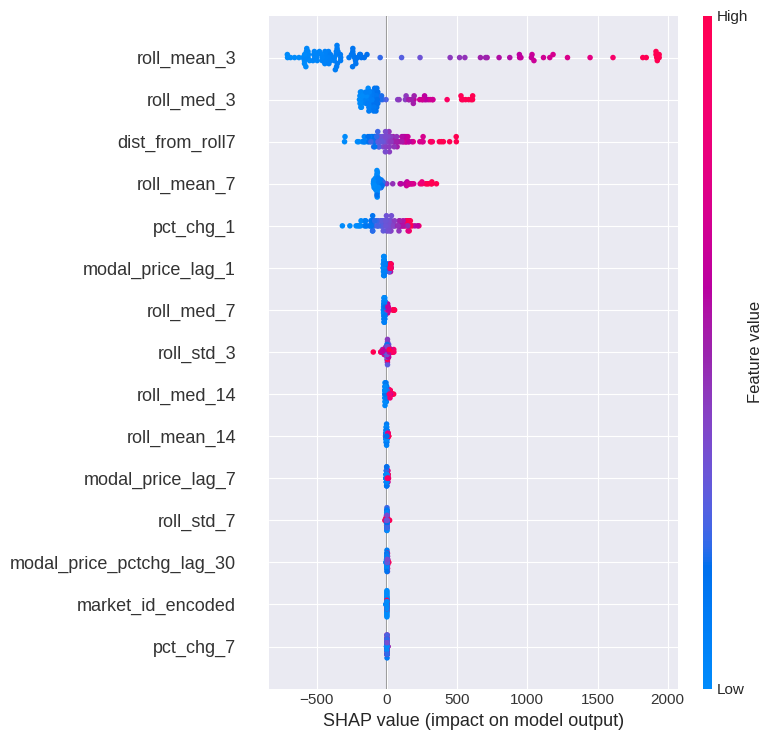


🔝 Top 10 Features by SHAP Importance:
   roll_mean_3                    637.7269
   roll_med_3                     176.2831
   dist_from_roll7                119.8625
   roll_mean_7                    97.8364
   pct_chg_1                      92.6683
   modal_price_lag_1              18.0309
   roll_med_7                     17.6829
   roll_std_3                     13.7299
   roll_med_14                    11.7913
   roll_mean_14                   4.4393


In [26]:

# ============================================================================
# SECTION 21: SHAP FEATURE EXPLANATIONS
# ============================================================================

print("\n" + "="*80)
print("🔍 SHAP FEATURE EXPLANATIONS")
print("="*80)

try:
    explainer = shap.TreeExplainer(xgb_model)
    shap_sample_size = min(100, len(X_test))
    X_shap = X_test.head(shap_sample_size)
    shap_values = explainer.shap_values(X_shap)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap, show=False, max_display=15)
    plt.tight_layout()
    if params['save_plots']:
        shap_path = os.path.join(WORKING_DIR, f'shap_summary_{timestamp}.png')
        plt.savefig(shap_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved SHAP summary plot: {shap_path}")
    plt.show()

    shap_importance = pd.DataFrame({
        'feature': X_train.columns,
        'mean_abs_shap': np.abs(shap_values).mean(axis=0)
    }).sort_values('mean_abs_shap', ascending=False)

    print("\n🔝 Top 10 Features by SHAP Importance:")
    for i, row in shap_importance.head(10).iterrows():
        print(f"   {row['feature']:<30} {row['mean_abs_shap']:.4f}")

except Exception as e:
    print(f"⚠️  SHAP analysis failed: {e}")

